# VEP VS LAMBDA

## Introductions

The aim of the project is to compare the within-subject variability in single trials of ERPs' P100 component to that of FRPs' lambda component. If the lambda response is less variable (inducing less within-subject variance) than the P1, it might be a more reliable index as a measure of delay in conduction in MS patients.

Multiple Sclerosis (MS) is a chronic demyelinating disease of the central nervous system, changing white matter structure and leaving lesions (Compston & Coles, 2008). Optic neuritis (ON) is a common symptom of multiple sclerosis (MS) and therefore commonly used for MS detection and prognosis. The VEP P100 component can be used to detect ON, as MS pataints tend to exhibit larger VEP P100 latency. 

Event-Related potentials (ERPs) are VEPs elicited by an external stimulus. Fixation-Related Potentials (FRPs) are VEPs elicited by self driven eye-movements. They are calculated locking EEG activity to the offset of an eye movement, that is, to fixation onset, rather than a change in the external stimulus, and are thought to reflect the afferent inflow of information due to release from saccadic suppression. The most prominent component of the Fixation-Related VEP is a sharp positive peak in occipital electrodes with a latency of about 80 msec from fixation onset, called the lambda response.   

Early studies comparing the P100 component of pattern-reversal ERPs to the FRPs lambda response (Billings, 1989; Scott et al., 1981) suggest that FRPs can be an index of visual information processing, similar to ERPs since both components are sensitive to low-level visual stimulus properties such as illuminance, contrast, check-size of the checkerboard etc.

The average peak latency of the Lambda response is slightly earlier than that of the P100 component and the amplitude, on average, is larger than that of the P100.

Usually, in order to detect the saccade onset of FRPs, an eye tracker is used. However, eye tracker is a disadvantage for clinical use as it is less available. Therefore, we checked the possibilty to use the EOG channels of EEG instead of eye tracker to detect saccades. 

## Data
For this stage of the project, existing data evoked by categorical stimuli (faces and eggs\watches) was used.

The data was collected from 10 participants, adults with no reported neurological illnesswith normal or corrected to normal visual acuity by their report. EEG was acquired using an Active 2 system (Biosemi, The Netherlands) from 64 electrodes mounted on an elastic cap according to the extended 10–20 system, at a sampling rate of 1024 Hz.

In [2]:
import jdc
import os
import sys
import mne
import numpy as np
from mne.externals.pymatreader import read_mat
from scipy.signal import find_peaks
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import savemat
os.chdir("/Users/eyalr/Documents/vepvslambda/dataWithEyetracker/newData")
sys.path.insert(0, "/Users/eyalr/Documents/vepvslambda/dataWithEyetracker")
from scipy import stats, signal
mne.set_log_level(verbose="CRITICAL")
import scipy
mne.viz.set_3d_backend("notebook")

In [3]:
plots_dir = "plots"
channel_for_plots = "O2"
channels_for_epochs = ["O1", "O2", "P10"]

## Part 1 - Detect Saccade Onset from EOG Channels

In order to use EOG channels instead of eye tracker to detect saccades onset.

#### Preprocessing:

In this stage, eye blinks were cleaned from the data using ICA. It is important to clean only blinks (and not other eye movements), other eye movements in the EOG channels are used for the saccade detection. 


#### Method:
The method described in Keren & Yuval-Greenberg, 2010 was used to detect saccades using the EOG channels:
1. Calculate REOG channel. REOG = (HEOGR + HEOGL + VEOGS + VEOGI)/4 − Pz.
2. Pass REOG channel through a “matched filter” (time- reversed template SP) with an impulse response composed of the average saccade-related potential (SRP4), high-pass filtered at 30 Hz to compensate for the smoothing effect of averaging, time-reversed (to counteract the reversal inherent to the convolution operation), multiplied by an 80 ms Hanning window and normalized. This filter produced the best results in Keren & Yuval-Greenberg, 2010 out of the four filter used.
3. Calculate the mean and std of the filtered channel. Each data point above a threshold of mean+3.5*std was regarded as a detected saccade.

In [4]:
SRPfilt = [0,   -0.0000,   -0.0001,   -0.0002,  -0.0002,   -0.0001,    0.0001,    0.0003,    0.0007,    0.0015,   0.0028,
    0.0050,    0.0080,    0.0114,    0.0151,    0.0188,    0.0217,    0.0241,    0.0267,    0.0272,    0.0271,    0.0287,
    0.0329,    0.0391,    0.0462,    0.0544,    0.0605,    0.0602,    0.0447,    0.0030,   -0.0672,   -0.1615,   -0.2631,
   -0.3490,   -0.3965,   -0.3834,   -0.3045,   -0.1706,   -0.0109,    0.1349,    0.2355,    0.2789,    0.2707,    0.2271,
    0.1683,    0.1100,    0.0631,    0.0319,    0.0174,   0.0142,    0.0193,    0.0274,    0.0312,    0.0303,    0.0257,
    0.0183,    0.0088,   -0.0007,   -0.0086,   -0.0152,   -0.0198,   -0.0221,   -0.0229,   -0.0230   -0.0219,   -0.0199,
   -0.0179,   -0.0157,   -0.0129,   -0.0101,   -0.0070,   -0.0042,   -0.0020,   -0.0003,    0.0009,    0.0013,    0.0013,
    0.0011,    0.0008,    0.0005,    0.0002,    0.0001,    0.0000,         0]

def filterSRP(x, fs=1024):
    # resample to 1024 if necessary
    if fs != 1024:
        x = resmaple(x, fs, 1024)
    # Number of time-samples in the filter
    n = len(SRPfilt)
    SPonset = 28

    x = np.convolve(x, SRPfilt[::-1])
    x = x[n - SPonset: -SPonset + 2]

    # resample back if necessary
    if fs != 1024:
        x = resmaple(x, 1024, fs)

    return x


In [5]:
class Participant:
    def __init__(self, participant):
        self.participant = participant

        self.only_blinks_data = read_mat(f"S{self.participant}_data_ica_onlyBlinks.mat")['dat']
        self.r = np.arange(self.only_blinks_data.shape[0])

        self.only_blinks_data = np.swapaxes(self.only_blinks_data, 0, 1)

        self.interp_data = read_mat(f"S{self.participant}_data_interp.mat")['data']
        self.interp_data = np.swapaxes(self.interp_data, 0, 1)
        self.channels = pd.read_csv(f"{self.participant}_channels.csv")

        self.info_data = pd.read_csv(f"{self.participant}_info.csv")

        self.start_idx = self.info_data[self.info_data["Codes"] == 11]['latency'].to_numpy()
        self.end_idx = self.info_data[self.info_data["Codes"] == 12]['latency'].to_numpy()
        self.trials_length = np.cumsum(self.end_idx - self.start_idx)

        self.epochs_erp_sacc_fname = os.path.join('epochs', f'{self.participant}-erp-sacc-epo.fif')
        self.epochs_frp_et_sacc_fname = os.path.join('epochs', f'{self.participant}-frp-et-sacc-epo.fif')
        self.epochs_frp_et_fix_fname = os.path.join('epochs', f'{self.participant}-frp-et-fix-epo.fif')
        self.epochs_frp_eog_sacc_fname = os.path.join('epochs', f'{self.participant}-frp-eog-sacc-epo.fif')

        self.channel_for_plots = "O2"

        self.calc_eye_tracker_sacc()

        self.calc_reog_channel()

        self.calc_eog_sacc()
        
        self.calc_events()

        self.get_epochs()

    def ch_idx(self, channel):
        return self.channels.index[self.channels['T'] == channel].item()

    def filter_trials(self, channel):
        return channel[((self.r >= self.start_idx[:, None]) & (self.r < self.end_idx[:, None])).any(0)]

    def calc_eye_tracker_sacc(self):
        self.eye_tracker_sacc_idx = self.info_data[self.info_data["Codes"] == 1]['SacOnset'].to_numpy().astype('int64')
        self.eye_tracker_sacc_vec = np.zeros_like(self.only_blinks_data[0, :])
        np.put(self.eye_tracker_sacc_vec, ind=self.eye_tracker_sacc_idx, v=1)


    def calc_reog_channel(self):

        self.reog_channel = (self.only_blinks_data[self.ch_idx('LHEOG'), :] + self.only_blinks_data[self.ch_idx('RHEOG'), :] +
                        self.only_blinks_data[self.ch_idx('RVEOGS'), :] + self.only_blinks_data[self.ch_idx('RVEOGI'), :]) \
                       / 4 - self.only_blinks_data[self.ch_idx('Pz'), :]

    def calc_eog_sacc(self, std_factor=3.5, plot=False):
        self.SRPed_data = filterSRP(self.reog_channel, 1024)[:-1]

        mean = self.SRPed_data.mean()
        std = self.SRPed_data.std()

        above_threshold_idx = find_peaks(self.SRPed_data, height=mean + std_factor * std)[0]
        above_threshold = np.zeros_like(self.SRPed_data)
        np.put(above_threshold, ind=above_threshold_idx, v=1)

        mask = ((self.r >= self.start_idx[:, None]) & (self.r < self.end_idx[:, None])).any(0)

        self.above_threshold = np.zeros_like(self.SRPed_data)
        self.above_threshold[mask] = above_threshold[mask]

        self.above_threshold_idx = np.squeeze(np.argwhere(self.above_threshold))
    
    def calc_events(self):
        self.eye_tracker_erp_idx = self.info_data[(self.info_data["NewCodes"] // 10000 % 10 == 2) &
                                             (self.info_data["NewCodes"] // 1000 % 10 == 0)]['latency'].to_numpy().astype('int64')
        self.eye_tracker_erp_vec = np.zeros_like(self.only_blinks_data[0, :])
        np.put(self.eye_tracker_erp_vec, ind=self.eye_tracker_erp_idx, v=1)

        self.eye_tracker_frp_sacc_idx = self.info_data[(self.info_data["NewCodes"] // 10000 % 10 == 1) &
                                             (self.info_data["NewCodes"] // 10 % 10 == 1) &
                                             (self.info_data["NewCodes"] // 1000 % 10 == 0)]['SacOnset'].to_numpy().astype('int64')
        self.eye_tracker_frp_sacc_vec = np.zeros_like(self.only_blinks_data[0, :])
        np.put(self.eye_tracker_frp_sacc_vec, ind=self.eye_tracker_frp_sacc_idx, v=1)

        self.eye_tracker_frp_fix_idx = self.info_data[(self.info_data["NewCodes"] // 10000 % 10 == 1) &
                                                       (self.info_data["NewCodes"] // 10 % 10 == 1) &
                                                       (self.info_data["NewCodes"] // 1000 % 10 == 0)]['latency'].to_numpy().astype('int64')
        self.eye_tracker_frp_fix_vec = np.zeros_like(self.only_blinks_data[0, :])
        np.put(self.eye_tracker_frp_fix_vec, ind=self.eye_tracker_frp_fix_idx, v=1)


        self.eog_frp_idx = self.above_threshold_idx
        self.eog_frp_vec = np.zeros_like(self.only_blinks_data[0, :])
        np.put(self.eog_frp_vec, ind=self.eog_frp_idx, v=1)
    
    def calc_epochs(self):
        
        info = mne.create_info(ch_names=["O2", "O1", "P10", "ERP", "FRP_ET_SACC", "FRP_ET_FIX", "FRP_EOG"], sfreq=1024, ch_types=['eeg', 'eeg', 'eeg', 'stim', 'stim', 'stim', 'stim'])
        data = self.interp_data[[self.ch_idx("O2"), self.ch_idx("O1"), self.ch_idx("P10")], :]

        data = np.vstack([data, self.eye_tracker_erp_vec, self.eye_tracker_frp_sacc_vec, self.eye_tracker_frp_fix_vec, self.eog_frp_vec])

        raw = mne.io.RawArray(data=data, info=info)

        erp_events = mne.find_events(raw=raw, stim_channel="ERP")
        frp_et_sacc_events = mne.find_events(raw=raw, stim_channel="FRP_ET_SACC")
        frp_et_fix_events = mne.find_events(raw=raw, stim_channel="FRP_ET_FIX")
        frp_eog_events =mne.find_events(raw=raw, stim_channel="FRP_EOG")


        self.erp_epochs = mne.Epochs(raw=raw, events=erp_events, tmin=-0.2, tmax=0.6, preload=True)
        self.erp_epochs.save(fname=self.epochs_erp_sacc_fname, overwrite=True)

        self.frp_et_sacc_epochs = mne.Epochs(raw=raw, events=frp_et_sacc_events, tmin=-0.2, tmax=0.6, preload=True)
        self.frp_et_sacc_epochs.save(fname=self.epochs_frp_et_sacc_fname, overwrite=True)

        self.frp_et_fix_epochs = mne.Epochs(raw=raw, events=frp_et_fix_events, tmin=-0.2, tmax=0.6, preload=True)
        self.frp_et_fix_epochs.save(fname=self.epochs_frp_et_fix_fname, overwrite=True)

        self.frp_eog_epochs = mne.Epochs(raw=raw, events=frp_eog_events, tmin=-0.2, tmax=0.6, preload=True)
        self.frp_eog_epochs.save(fname=self.epochs_frp_eog_sacc_fname, overwrite=True)

        epochs = {"ERP": self.erp_epochs, "FRP_ET_SACC": self.frp_et_sacc_epochs, "FRP_ET_FIX": self.frp_et_fix_epochs, "FRP_EOG": self.frp_eog_epochs}
        mat_data = {"O1": {}, "O2": {}, "P10": {}}
        for channel in channels_for_epochs:
            for kind in epochs.keys():
                mat_data[channel][kind] = np.squeeze(epochs[kind].get_data(picks=channel))
        mdict = {"data" : mat_data}
        with open(f"S{self.participant}_epochs.mat", 'wb') as f:
            savemat(f, mdict)

    def get_epochs(self):
        if os.path.isfile(self.epochs_erp_sacc_fname) and os.path.isfile(self.epochs_frp_et_sacc_fname) \
                and os.path.isfile(self.epochs_frp_eog_sacc_fname) and os.path.isfile(self.epochs_frp_et_fix_fname):
            self.erp_epochs = mne.read_epochs(fname=self.epochs_erp_sacc_fname)
            self.frp_et_sacc_epochs = mne.read_epochs(fname=self.epochs_frp_et_sacc_fname)
            self.frp_et_fix_epochs = mne.read_epochs(fname=self.epochs_frp_et_fix_fname)
            self.frp_eog_epochs = mne.read_epochs(fname=self.epochs_frp_eog_sacc_fname)
        else:
            self.calc_epochs()

In [6]:
participants = {}
for i, participant_num in enumerate(range(101,111)):
    participant = Participant(str(participant_num))
    del participant.only_blinks_data
    del participant.interp_data
    participants[participant_num] = participant

/Users/eyalr/miniconda3/envs/mne/lib/python3.8/site-packages/mne/externals/pymatreader/utils.py:118: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
/Users/eyalr/miniconda3/envs/mne/lib/python3.8/site-packages/mne/externals/pymatreader/utils.py:118: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
/Users/eyalr/miniconda3/envs/mne/lib/python3.8/site-packages/mne/externals/pymatreader/utils.py:118: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
/Users/eyalr/miniconda3/envs/mne/lib/python3.8/site-packages/mne/externals/pymatreader/utils.py:118: UserWarning: Complex ob

In [7]:
%%add_to Participant
def plot_saccade_detection(self):
    mask = ((self.r >= self.start_idx[:, None]) & (self.r < self.end_idx[:, None])).any(0)
    raw_object_data = np.vstack([self.reog_channel[mask], self.SRPed_data[mask], self.eye_tracker_sacc_vec[mask]])
    raw_object_ch = ['REOG', 'REOG_filtered', 'ET_SACC']
    raw_object_ch_types = ['eeg'] * 2 + ['stim']
    raw_object_info = mne.create_info(raw_object_ch, sfreq=1024, ch_types=raw_object_ch_types)
    raw_object = mne.io.RawArray(data=raw_object_data,
                                 info=raw_object_info)
    events = mne.find_events(raw_object, stim_channel='ET_SACC')
    scalings = dict(eeg=5e2, stim=1e10)
    fig = raw_object.plot(n_channels=2, events=events, scalings=scalings, event_color={1: 'r'}, show=False)
    fig.suptitle(f"Figure 1",  y=1.01)
    plt.show()
    

Figure 1 includes 2 graphs. The upper is REOG channel and the lower is REOG channel after filtering. The vertical red lines are the saccades detected by the eye tracker.The filtered REOG channel peaks in correlation to the saccades onset.   

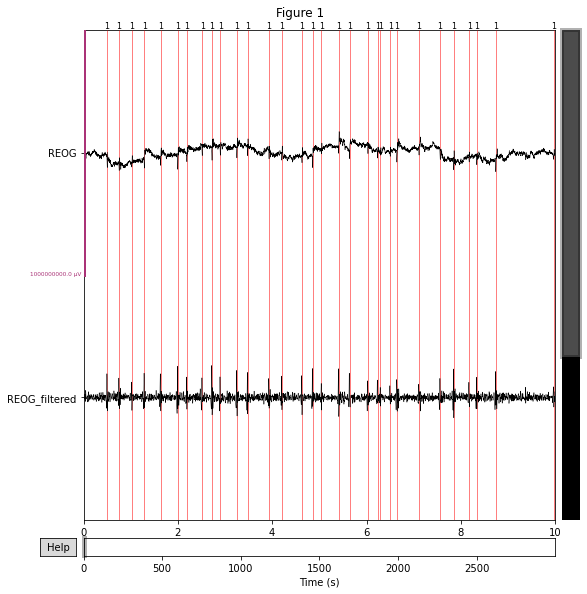

In [8]:
participant_num = 101
participants[participant_num].plot_saccade_detection()

## Evaluation Method

The method described in Keren & Yuval-Greenberg et al., 2009, was used to evaluate the detection method: using the eye tracker as true lables, hits were counted as the number of data points above the threshold, that had a "true" saccade detected by the eye tracker in the range of 8ms or less around them. Hits ratio is the number of hits divided by the number of data points above the threshold (hits + misses). The false alarms were counted as the number of data points above the threshold, that had no "true" saccade in that range around them. Flase alarms ratio is the number of false alarms devided by the total number of bins (of 16 ms) in which no true saccade onset occurred according to the eye tracker.

* hits_ratio = hits / num_above_threshold
* fals_alarms_ratio = count_sp_no_sacc / count_no_sacc

In [9]:
%%add_to Participant
def count_hits(self):
    as_strided = np.lib.stride_tricks.as_strided
    r = 9

    above_threshold_ext = np.concatenate((np.full(r, np.nan), self.above_threshold, np.full(r, np.nan)))

    windows = \
        as_strided(above_threshold_ext, (above_threshold_ext.shape[0], 2 * r + 1), above_threshold_ext.strides * 2)[
            self.eye_tracker_sacc_idx]

    detected = np.count_nonzero(np.sum(windows, axis=1))

    sacc_count = np.sum(self.eye_tracker_sacc_vec)

    return detected / sacc_count

def count_false_alarms(self):
    # above_threshold_trials = self.filter_trials(self.above_threshold)
    # eye_tracker_sacc_trials = self.filter_trials(self.eye_tracker_sacc_vec)

    section_len = 19
    N = self.above_threshold.shape[0] // section_len * section_len


    sacc_windows = np.reshape(self.eye_tracker_sacc_vec[:N], (-1, section_len))
    above_threshold_windows = np.reshape(self.above_threshold[:N], (-1, section_len))

    is_sacc = sacc_windows.sum(axis=1)
    count_no_sacc = np.count_nonzero(is_sacc == 0)

    is_sp = above_threshold_windows.sum(axis=1)
    is_sp = np.where(is_sacc == 0, is_sp, 0)
    count_sp_no_sacc = np.count_nonzero(is_sp)

    return count_sp_no_sacc / count_no_sacc


### Results
The mean hits ratio accross participants was 0.723, and mean false alarms ratio: 0.01089.
The results were similar to the results described in Keren & Yuval-Greenberg et al., 2009.

In [10]:
all_hits, all_fals_alarms = [], []
for i, participant_num in enumerate(range(101, 111)):
    participant = participants[participant_num]
    hits = participant.count_hits()
    all_hits.append(hits)
    false_alarms = participant.count_false_alarms()
    all_fals_alarms.append(false_alarms)
    print(f"participant {str(participant_num)} result: hits: {hits}, false alarms: {false_alarms}")
mean_hits = sum(all_hits) / len(all_hits)
mean_false_alarms = sum(all_fals_alarms) / len(all_fals_alarms)
print(f"mean result: hits: {mean_hits}, false alarms: {mean_false_alarms}")

participant 101 result: hits: 0.830037017451084, false alarms: 0.00945191531196236
participant 102 result: hits: 0.628453193155128, false alarms: 0.01367163827643166
participant 103 result: hits: 0.7348529411764706, false alarms: 0.013940959204643284
participant 104 result: hits: 0.7585064739536285, false alarms: 0.010732941908324741
participant 105 result: hits: 0.7932736809626658, false alarms: 0.011316818774445894
participant 106 result: hits: 0.8143950127514876, false alarms: 0.00975369211095974
participant 107 result: hits: 0.5930946291560102, false alarms: 0.013248802627292234
participant 108 result: hits: 0.685417568152315, false alarms: 0.006739846243891229
participant 109 result: hits: 0.6817144557991864, false alarms: 0.010313095761841912
participant 110 result: hits: 0.7103004291845494, false alarms: 0.009729297680678754
mean result: hits: 0.7230045401742525, false alarms: 0.010889900790047183


## Part 2 - ERP vs FRP Variance
### Preprocessing
For this stage, we removed all eye movement components using ICA, as we were interested in the brain activity.


### Method
Four types of epochs were created from the data:
1. ERPs
2. FRPs detected by eye tracker locked to fixation onset
3. FRPs detected by eye tracker locked to saccade onset
4. FRPs detected by EOG channels locked to saccade onset

### Initial Results for Evaluation
The within-subject single trial variability was compared.

#### Stimulus Graphs

In figure 2, each row includes 4 graphs represnting the four types of epochs per participant. 
In most cases, the P1 component of the ERPs graph is more relatively blurred, indicating variablity compared to the FRPs graphs, in which the lambda component is well defined.     
Note that the FRPs EOG graph is as well defined as the FRPs eye tracker graphs. 



In [11]:
def plot_stimulus_graph(erp_epochs, frp_et_sacc_epochs, frp_et_fix_epochs, frp_eog_epochs, participant):
    fig = plt.figure(constrained_layout=True, figsize=(40, 10))
    gs = fig.add_gridspec(10, 41)
    ax1 = fig.add_subplot(gs[:, :10])
    ax2 = fig.add_subplot(gs[:, 10:11])
    ax3 = fig.add_subplot(gs[:, 11:20])
    ax4 = fig.add_subplot(gs[:, 20:21])
    ax5 = fig.add_subplot(gs[:, 21:30])
    ax6 = fig.add_subplot(gs[:, 30:31])
    ax7 = fig.add_subplot(gs[:, 31:40])
    ax8 = fig.add_subplot(gs[:, 40:41])

    vmin=-4
    vmax=10

    erp_epochs.plot_image(picks=[channel_for_plots], title="ERP", evoked=False, axes=[ax1, ax2], show=False, vmin=vmin, vmax=vmax)
    frp_et_fix_epochs.plot_image(picks=[channel_for_plots], title="FRP ET FIX", evoked=False,
                                           axes=[ax3, ax4], show=False, vmin=vmin, vmax=vmax)
    frp_et_sacc_epochs.plot_image(picks=[channel_for_plots], title="FRP ET SACC", evoked=False,
                                           axes=[ax5, ax6], show=False, vmin=vmin, vmax=vmax)
    frp_eog_epochs.plot_image(picks=[channel_for_plots], title="FRP EOG SACC", evoked=False, axes=[ax7, ax8],
                                   show=False, vmin=vmin, vmax=vmax)
    
    if participant == 101:
        fig.suptitle(f"Figure 2\n participant: {participant} channel: {channel_for_plots}", size=20)
    else:
        fig.suptitle(f"participant: {participant} channel: {channel_for_plots}", size=20)
#     fig.savefig(f"plots/stimulus_{participant}_{channel_for_plots}.pdf")


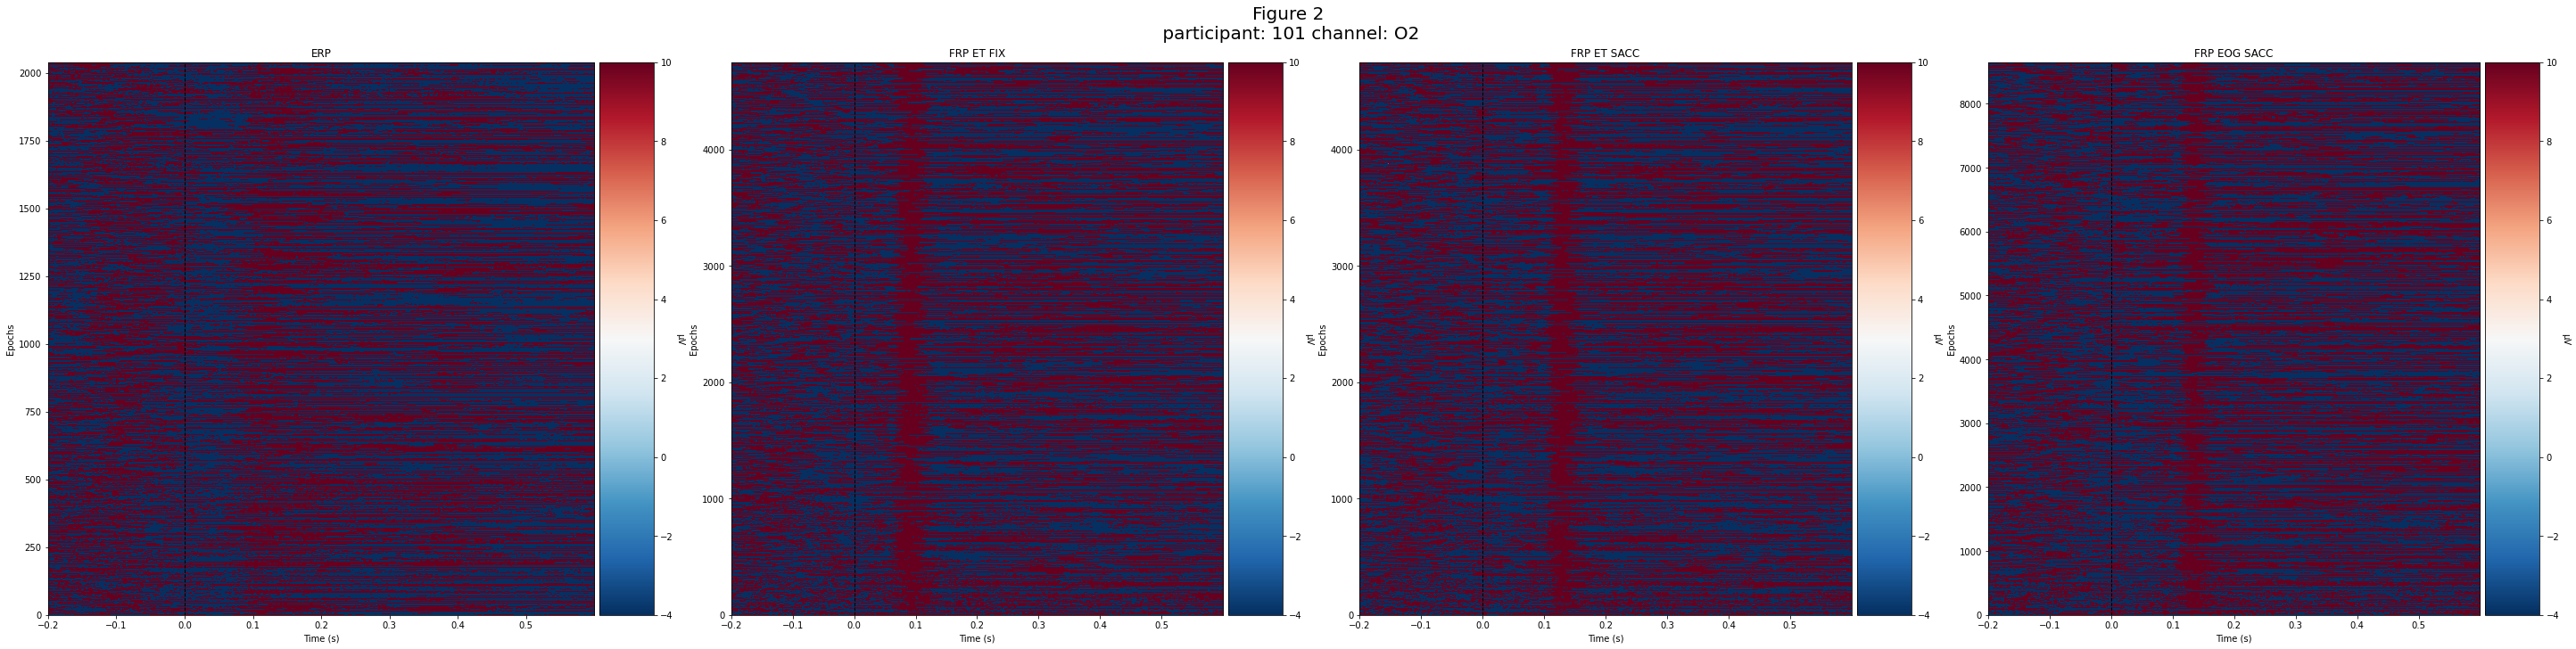

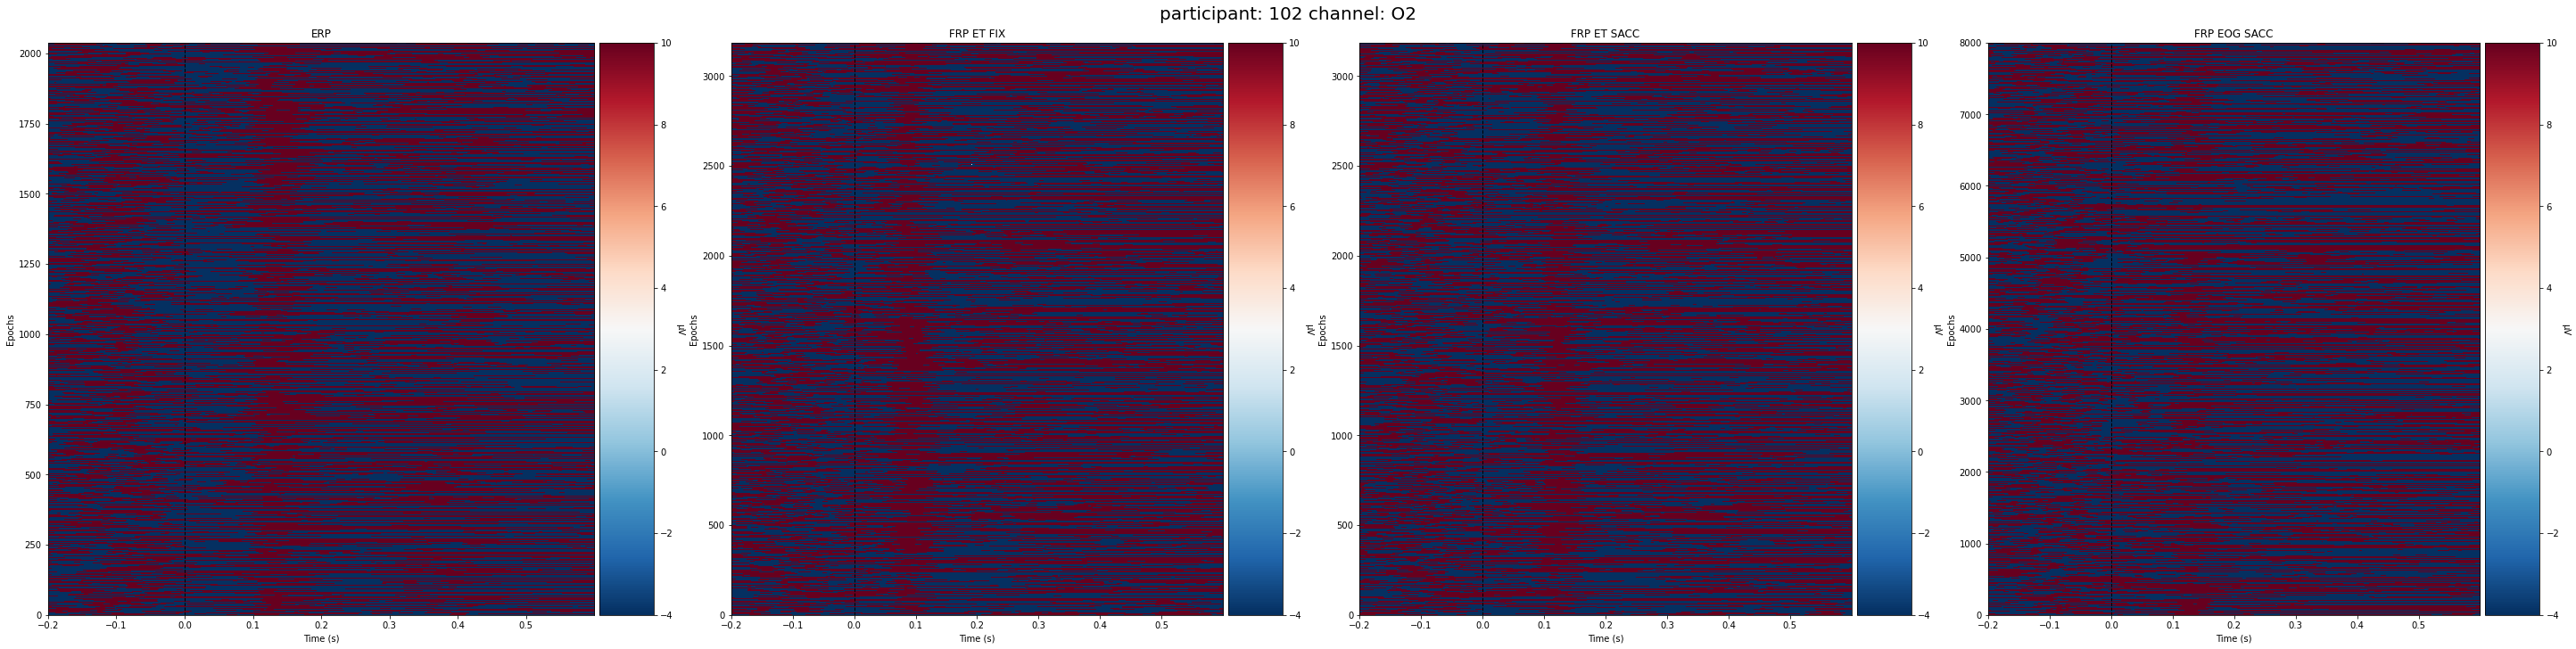

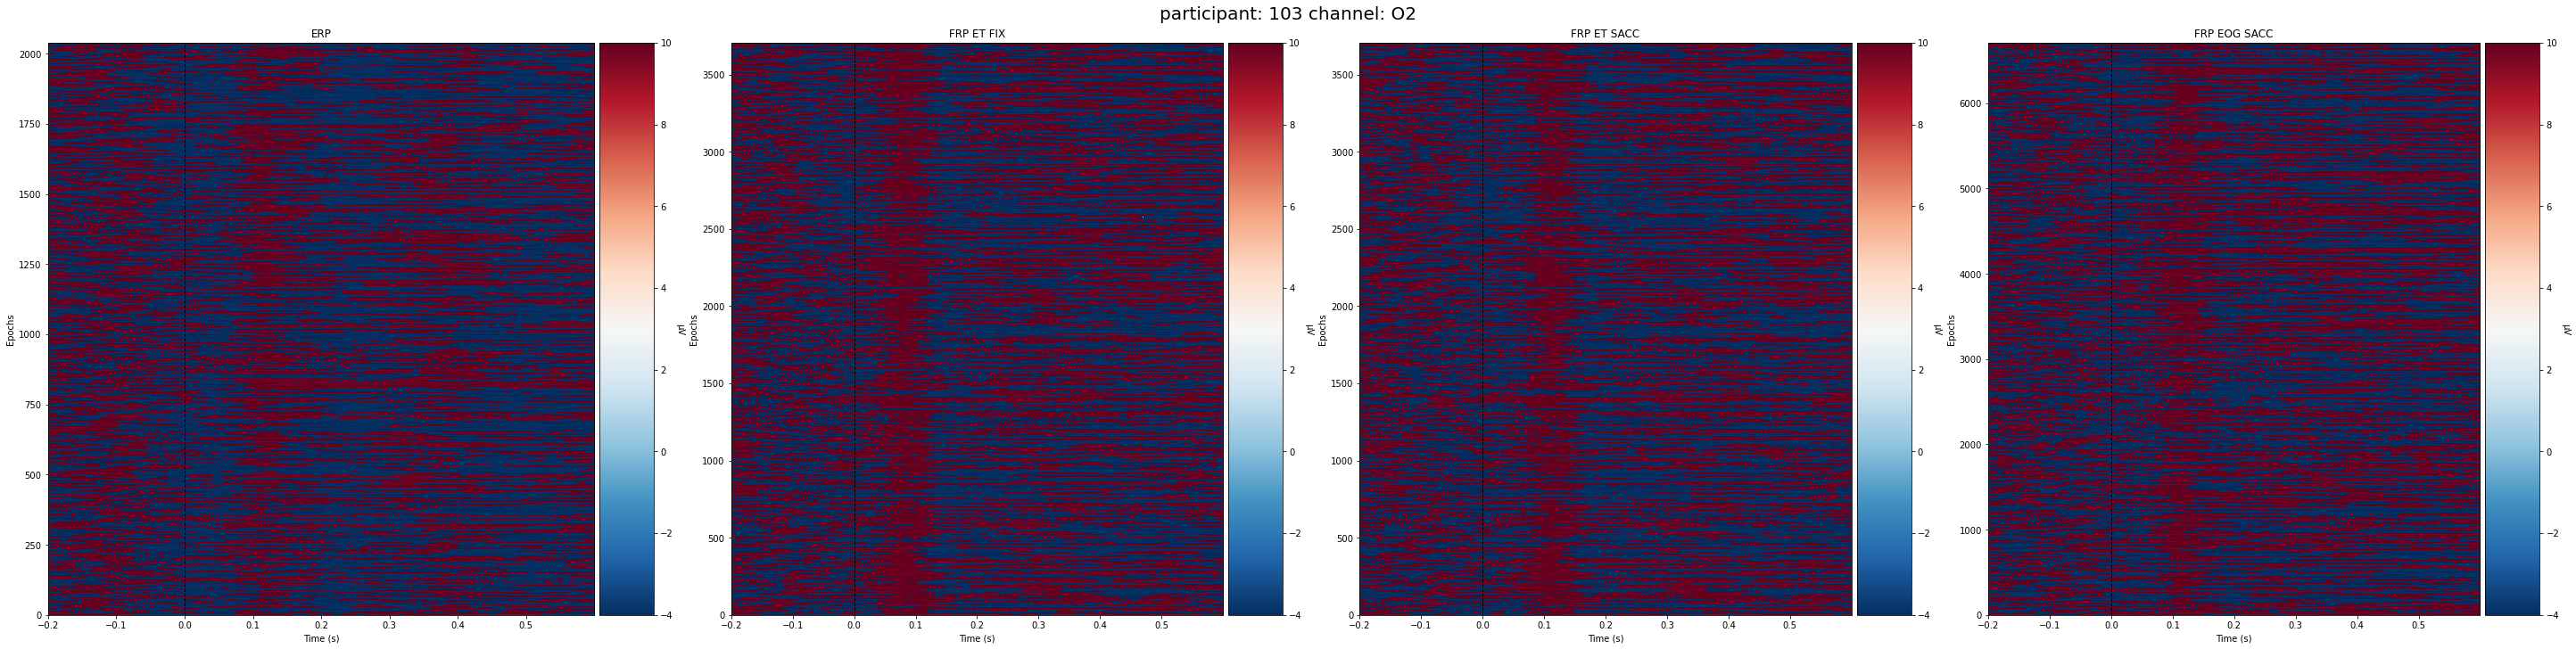

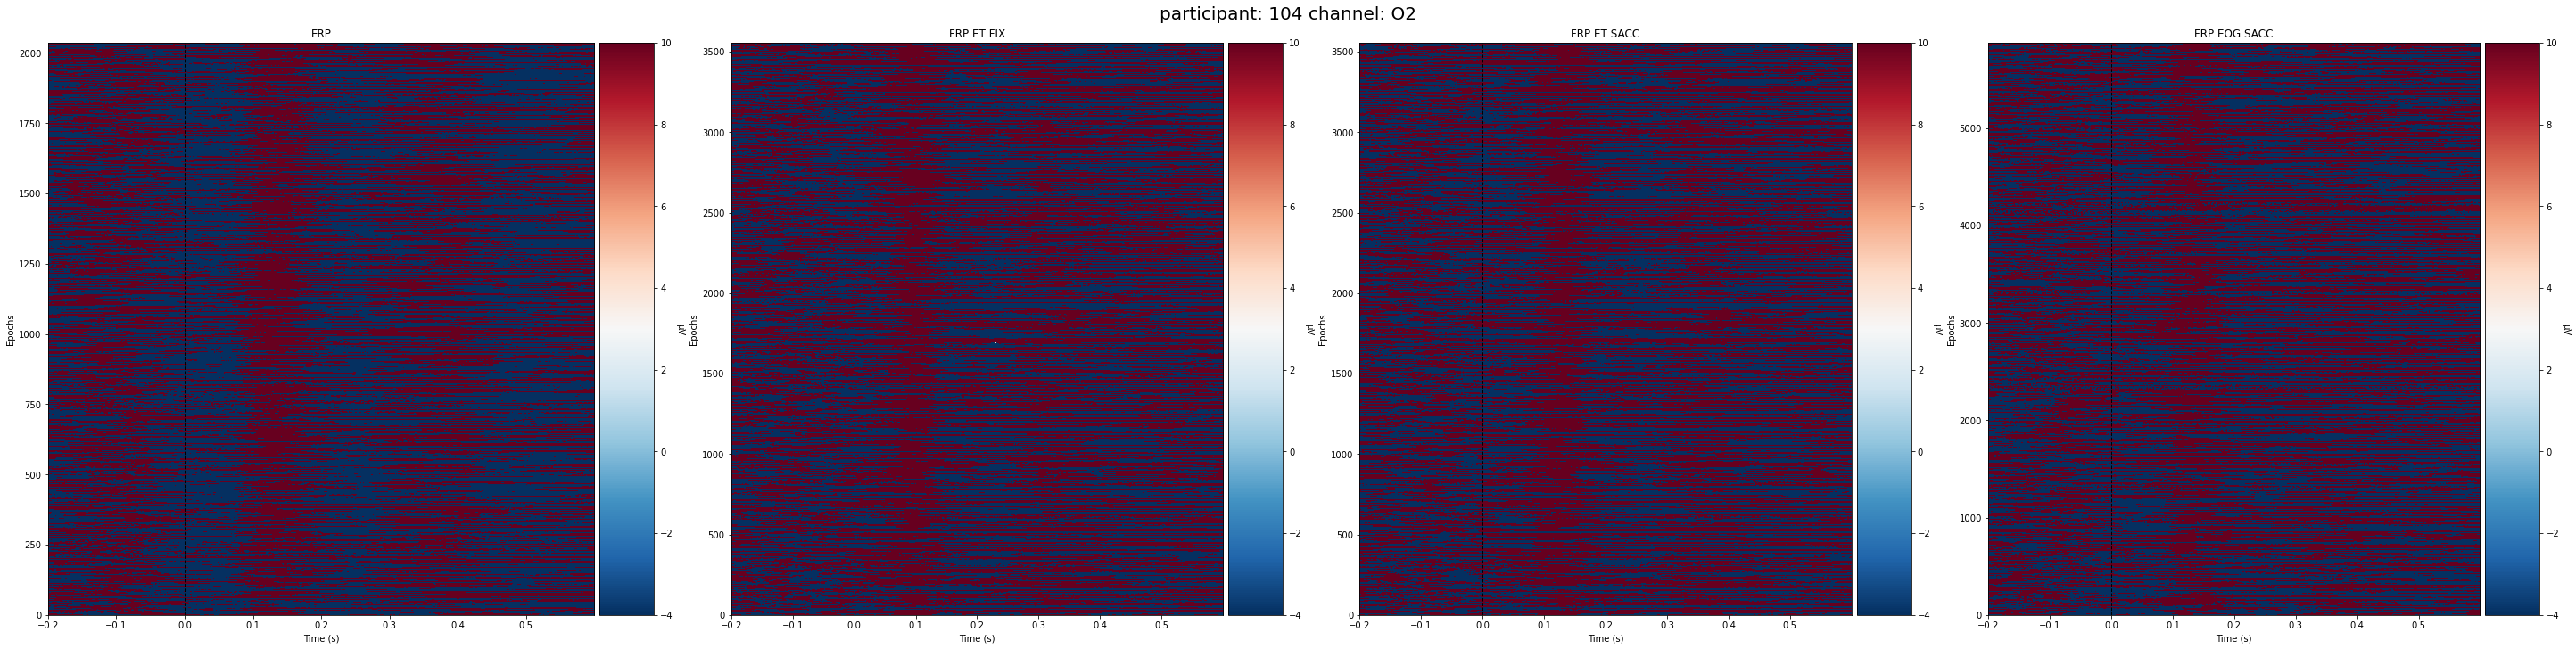

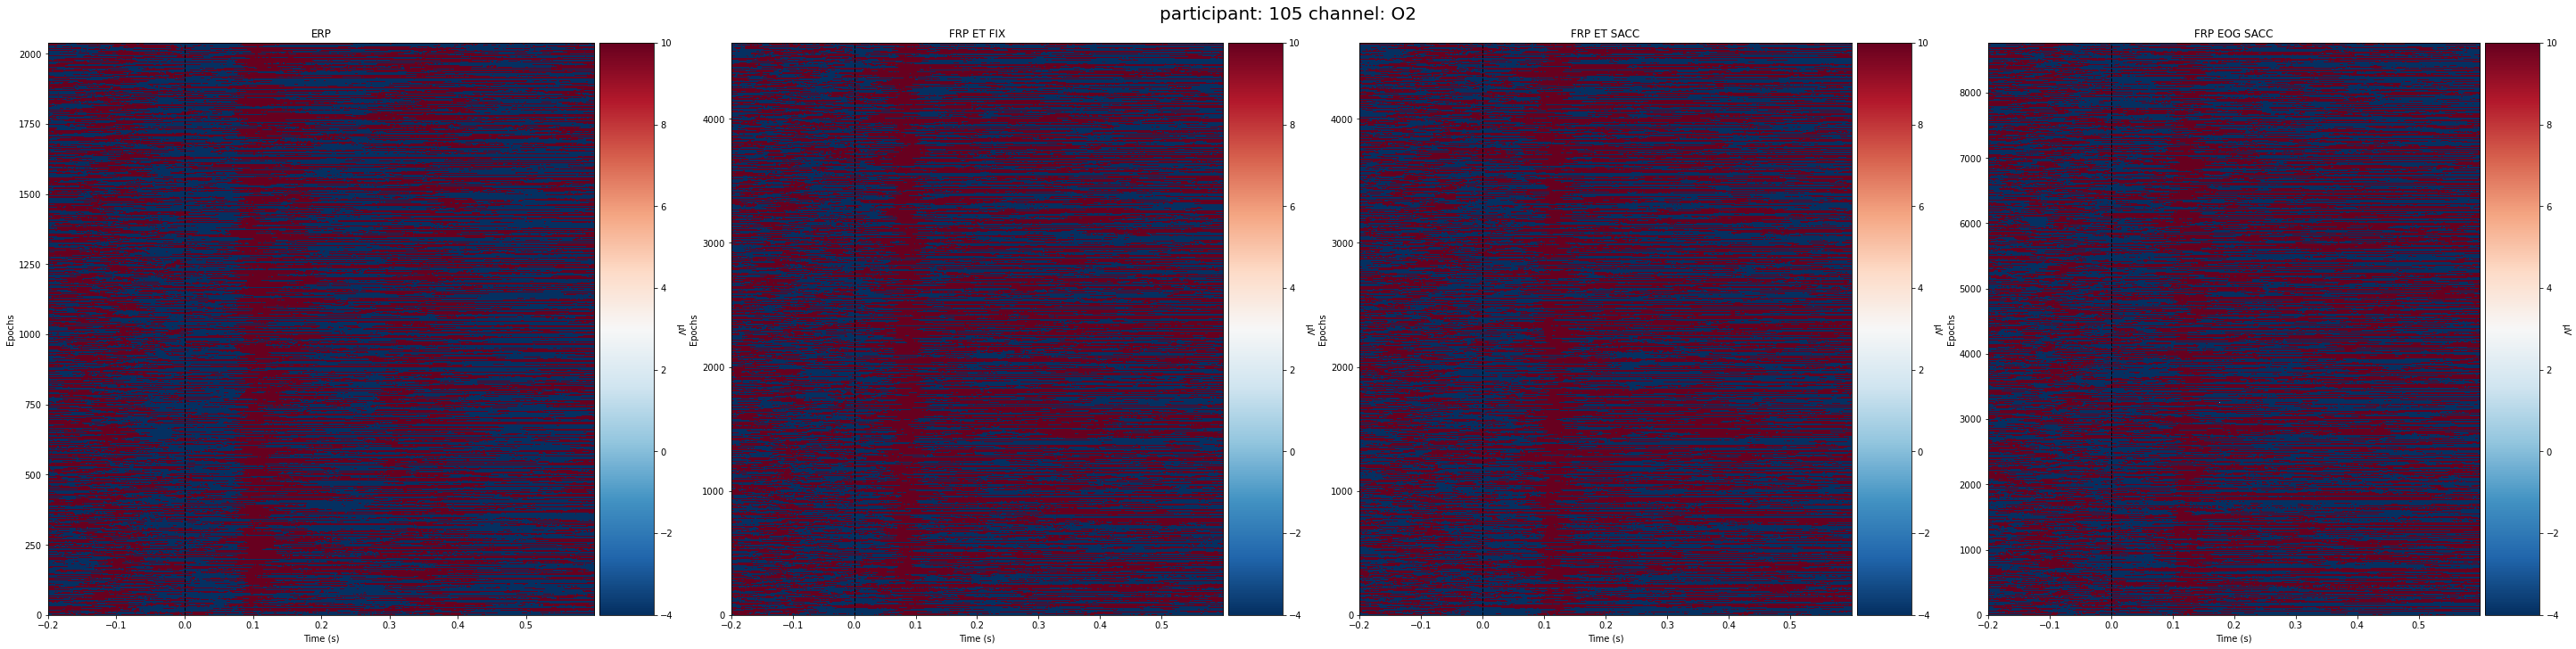

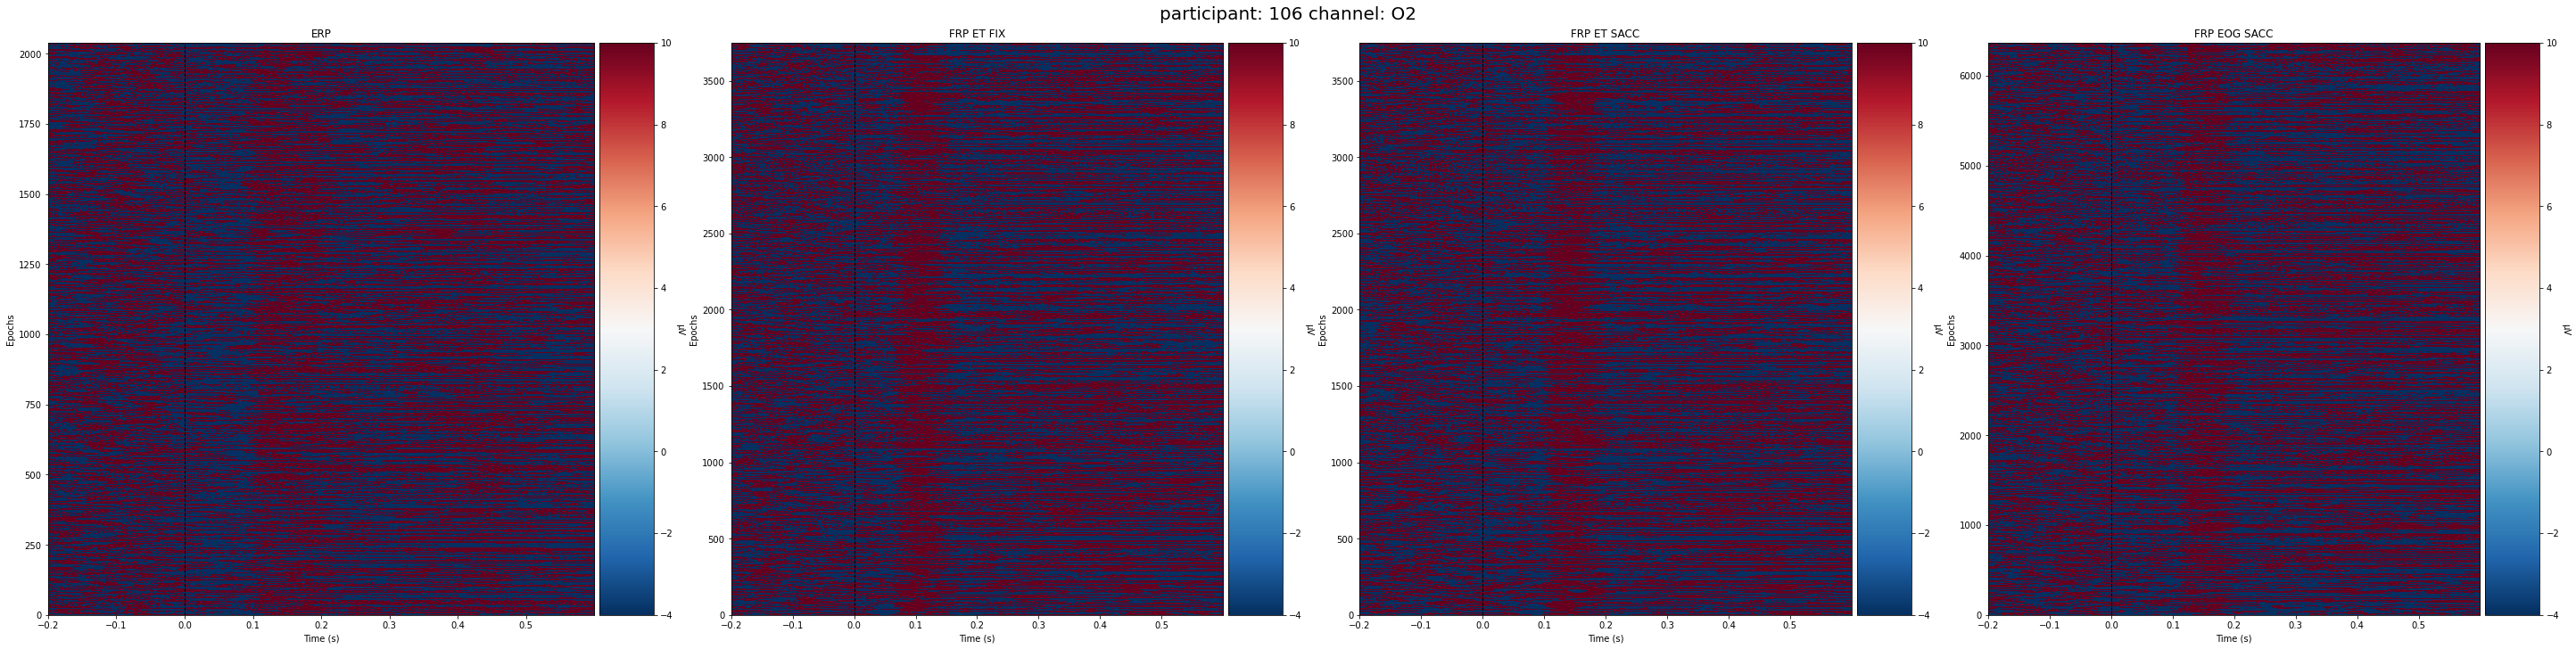

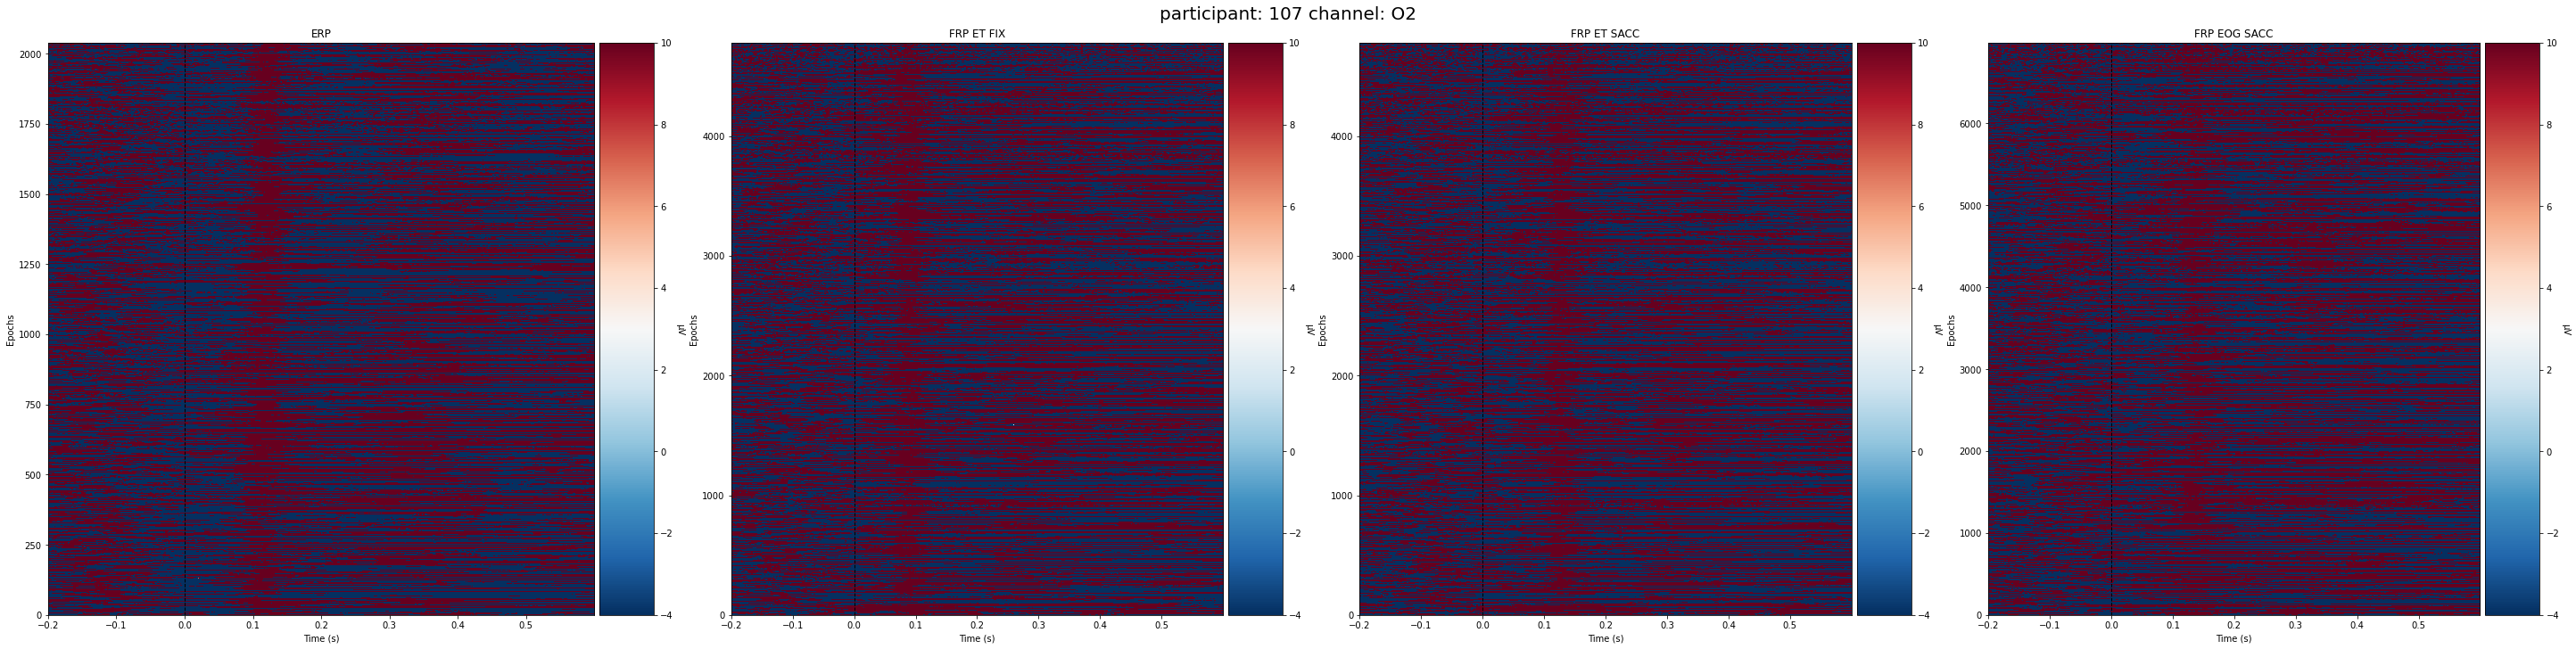

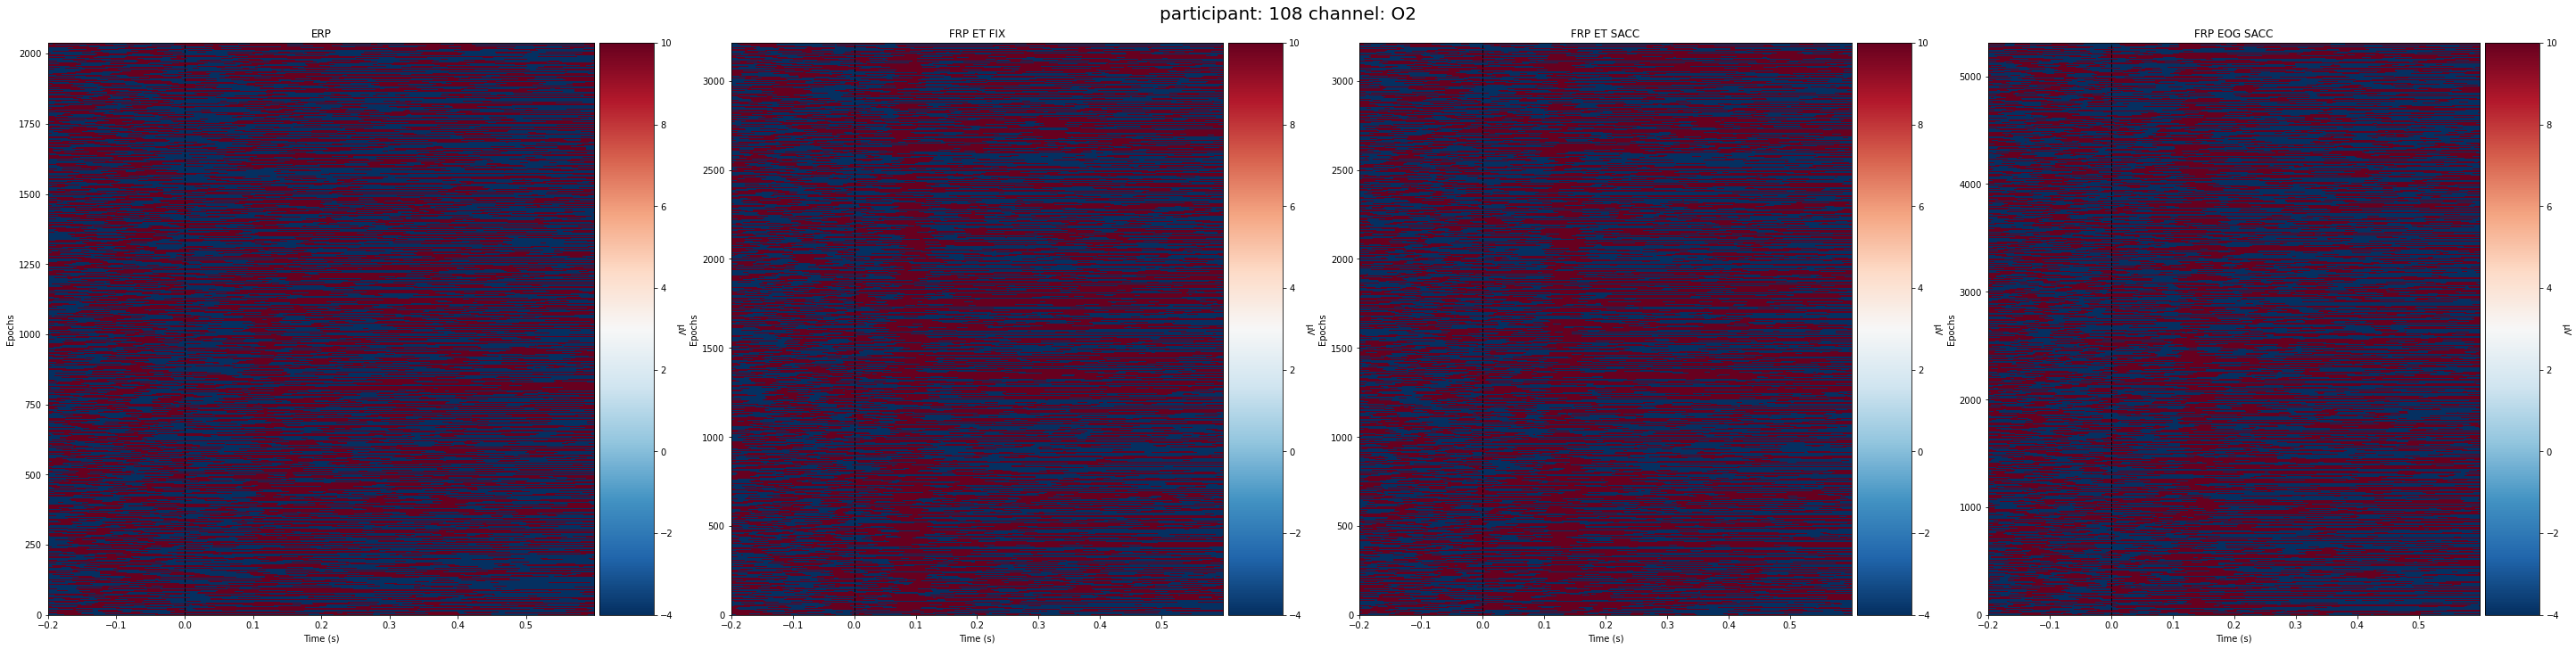

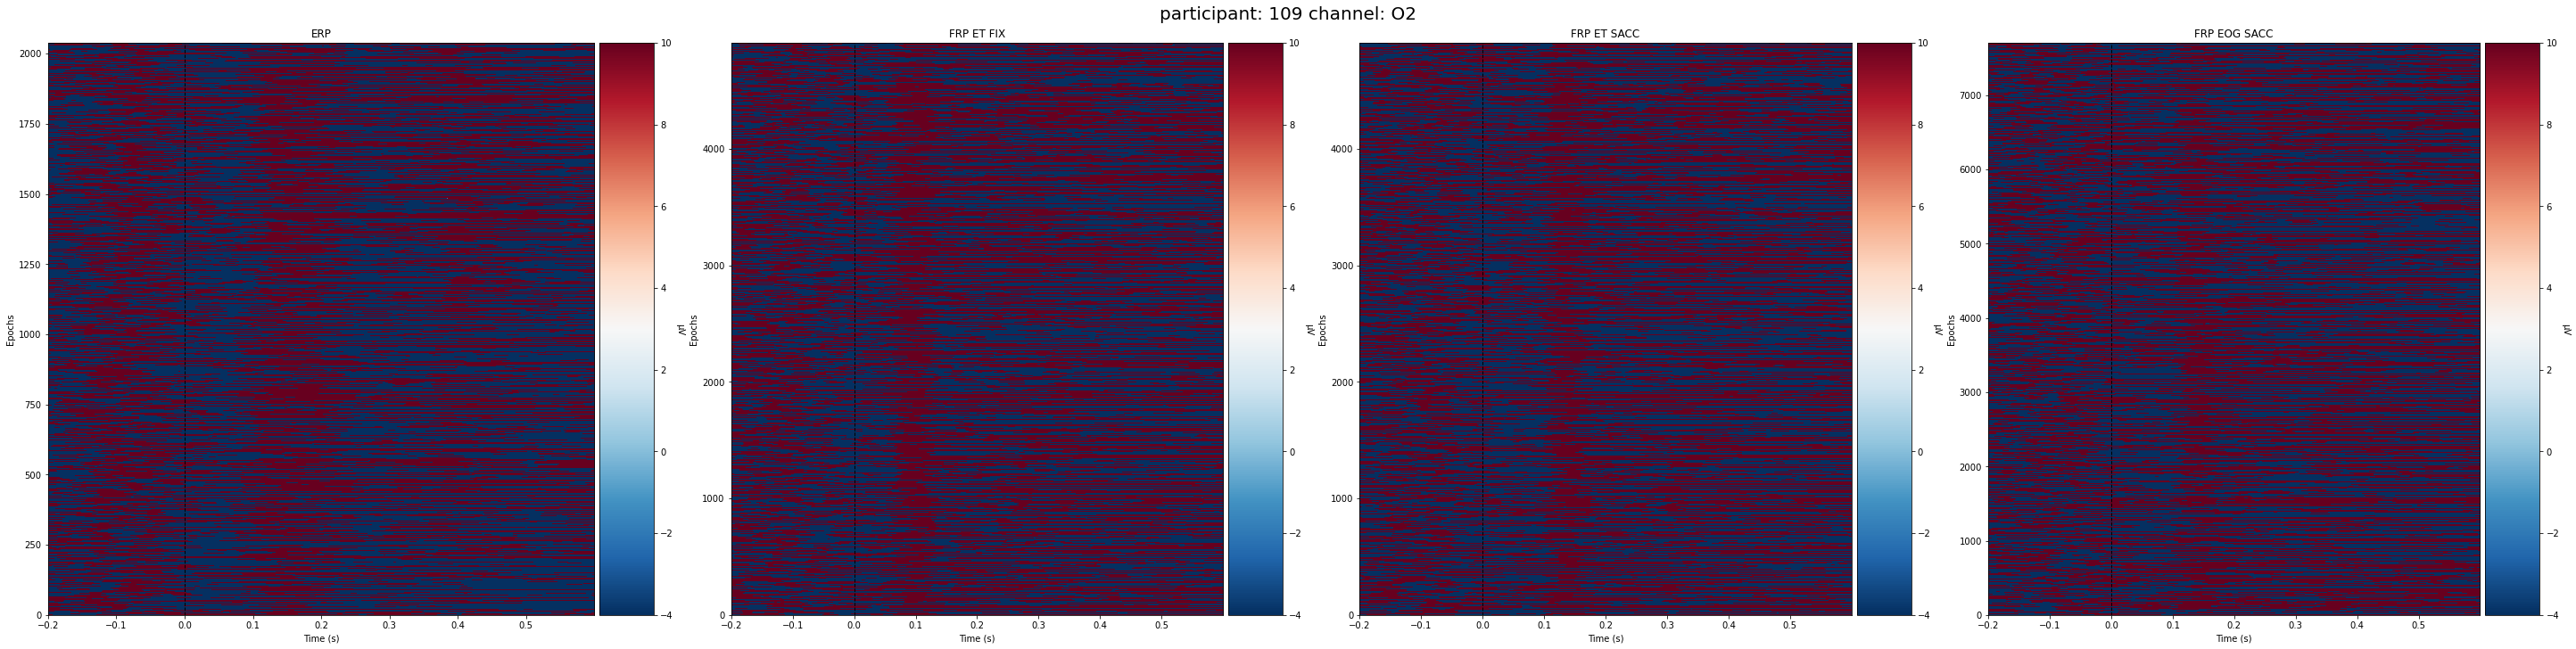

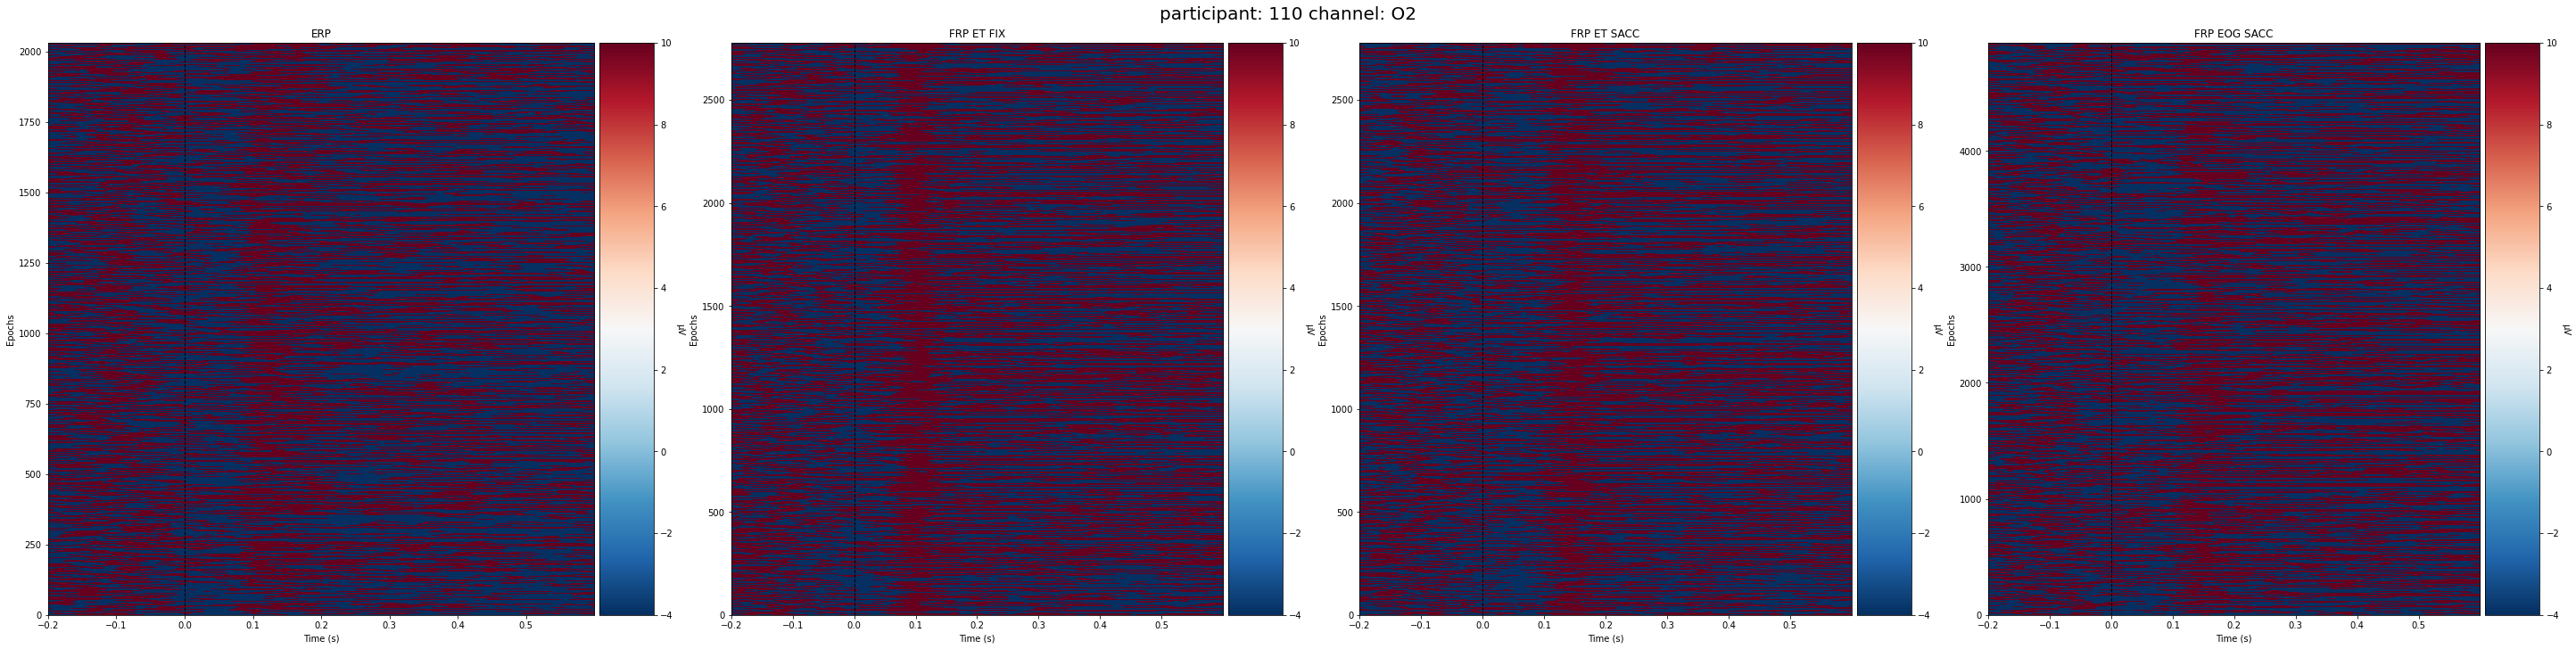

In [12]:
for i, participant_num in enumerate(range(101, 111)):
    participant = participants[participant_num]
    plot_stimulus_graph(participant.erp_epochs, participant.frp_et_sacc_epochs, participant.frp_et_fix_epochs, participant.frp_eog_epochs, participant_num)

#### Mean-Ci Grapths 
Figure 3 displays the mean and confidence interval across trails. In most cases, the confidence interval of the ERP graph is wider than that of the FRPs graphs. Note that the confidence interval of the FRPs EOG graph looks similar to the FRPs eye tracker graphs. 

In [13]:
%%add_to Participant
def plot_mean_ci(self):
    epochs = {"ERP": self.erp_epochs, "FRP ET SACC": self.frp_et_sacc_epochs, "FRP ET FIX": self.frp_et_fix_epochs, "FRP EOG": self.frp_eog_epochs}
    colors = {"ERP" : 'blue', "FRP ET SACC": 'red', "FRP ET FIX" : 'purple', "FRP EOG": 'green'}
    fig, axes = plt.subplots(1, 1)
    for kind in ["ERP", "FRP ET SACC", "FRP ET FIX", "FRP EOG"]:
        data = np.squeeze(epochs[kind].get_data(picks=self.channel_for_plots))
        times = epochs[kind].times
        mean = np.mean(data, axis=0)
        lower, upper = stats.t.interval(0.95, len(data)-1, loc=mean, scale=stats.sem(data, axis=0))
        axes.fill_between(times, lower,upper, color=colors[kind], alpha=0.2)
        axes.plot(times, mean, color=colors[kind], lw=1, label=kind)
    axes.legend()
    if self.participant == "101":
        axes.set_title(f"Figure 3\n participant: S{self.participant}, channel: {self.channel_for_plots}")
    else:    
        axes.set_title(f"participant: S{self.participant}, channel: {self.channel_for_plots}")
    axes.set_xlabel("time")
    axes.set_ylabel(r'$\mu$V')
#     fig.savefig(f"plots/mean_ci_{self.participant}_{channel_for_plots}.pdf")

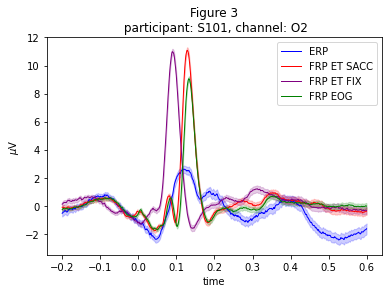

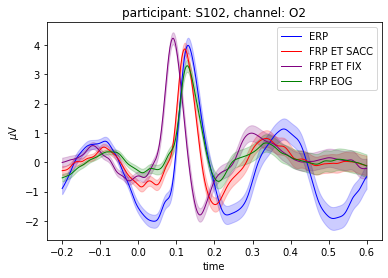

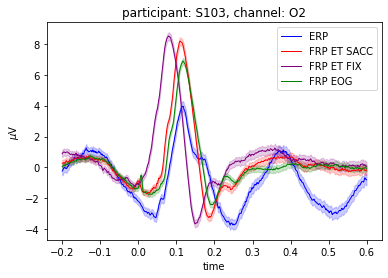

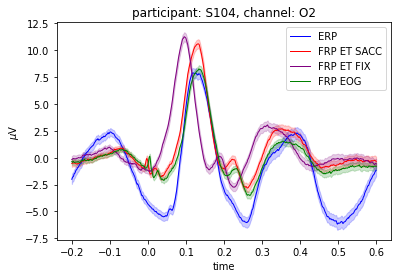

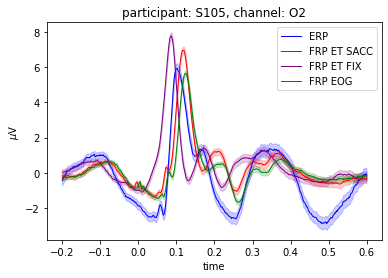

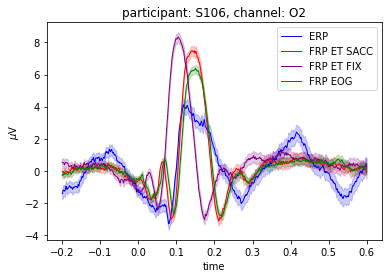

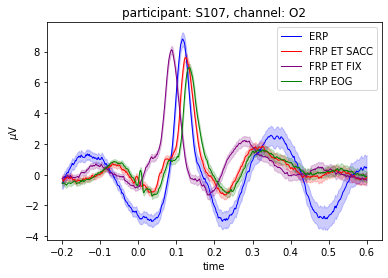

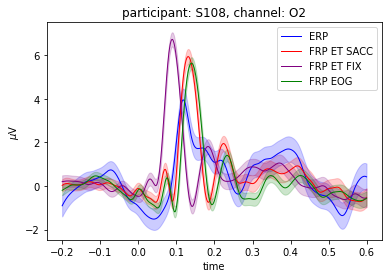

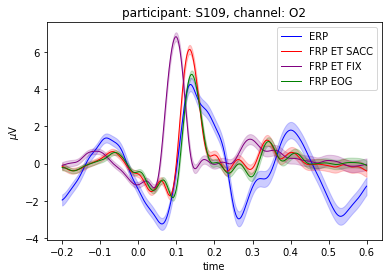

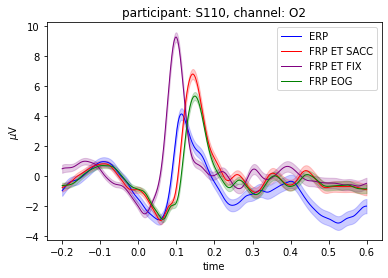

In [14]:
for i, participant_num in enumerate(range(101, 111)):
    participant = participants[participant_num]
    participant.plot_mean_ci()

### Evaluation
1. For each participant, calculate the mean across trials and find the peak (amplitude and latency)
2. For each trial, find the peak in the range of +-20ms around the mean peak (amplitude and latency)
3. Calculate the ci across the trials (amplitude and latency) and devide by the mean
4. Compare the scaled ci values
 

In [15]:
def plot_participant_amplitudes_latencies_graph(latency_amplitude_data):
    fig = plt.figure(constrained_layout=True, figsize=(20, 10))
    gs = fig.add_gridspec(10, 20)
    ax1 = fig.add_subplot(gs[:, :10])
    ax2 = fig.add_subplot(gs[:, 10:20])
    
    relevant_items = {key : latency_amplitude_data[key] for key in latency_amplitude_data.keys() if " ci" in key}
    latency_items = {key : latency_amplitude_data[key] for key in relevant_items.keys() if "latency" in key}
    amplitude_items = {key : latency_amplitude_data[key] for key in relevant_items.keys() if "amplitude" in key}

    ax1.bar(latency_items.keys(), latency_items.values())
    ax1.set_title(f"Latency")
    
    ax2.bar(amplitude_items.keys(), amplitude_items.values())
    ax2.set_title(f"Amplitude")
    
    fig.suptitle(f"{latency_amplitude_data['participant']} {latency_amplitude_data['channel']}")

In [28]:
%%add_to Participant
def calc_peaks_amplitudes_latencies(self):
    h_freq = 30
    self.erp_epochs.filter(l_freq=None, h_freq=h_freq)
    self.frp_et_sacc_epochs.filter(l_freq=None, h_freq=h_freq)
    self.frp_et_fix_epochs.filter(l_freq=None, h_freq=h_freq)
    self.frp_eog_epochs.filter(l_freq=None, h_freq=h_freq)
    
    
    range_around_peak = 30
    epochs = {"ERP": self.erp_epochs, "FRP ET SACC": self.frp_et_sacc_epochs, "FRP ET FIX": self.frp_et_fix_epochs, "FRP EOG": self.frp_eog_epochs}
    channel = "O2"
    
    latency_amplitude_data = {'participant': self.participant, 'channel': channel, 'range_around_peak': range_around_peak}
    
    for kind in ["ERP", "FRP ET SACC", "FRP ET FIX", "FRP EOG"]:
        data = np.squeeze(epochs[kind].get_data(picks=channel))
        mean = np.mean(data, axis=0)
        times = epochs[kind].times
        
        peaks_indices = scipy.signal.find_peaks(mean)[0]
        mean_peak_idx = peaks_indices[np.argmax(mean[peaks_indices])]
        mean_peak = mean[mean_peak_idx]
        mean_peak_time = times[mean_peak_idx]       
        
        latency_amplitude_data[f"{kind} latency mean"] = mean_peak_time
        latency_amplitude_data[f"{kind} amplitude mean"] = mean_peak

        latencies = []
        amplitudes = []
        for i in range(len(data)): 
            single_trial = data[i]
            single_trial_subrange = single_trial[mean_peak_idx-range_around_peak:mean_peak_idx+range_around_peak]
            
            count = 0
            peaks_indices = scipy.signal.find_peaks(single_trial_subrange)[0]
            if len(peaks_indices) != 0:
                peak_idx = peaks_indices[np.argmax(single_trial_subrange[peaks_indices])] + mean_peak_idx - range_around_peak
                peak = single_trial[peak_idx]
                peak_time = times[peak_idx]
            else:
                peak = np.max(single_trial_subrange)
                peak_idx_subrange = np.argmax(single_trial_subrange)
                peak_idx = mean_peak_idx - range_around_peak + peak_idx_subrange
                peak_time = times[peak_idx]

            latencies.append(peak_time)
            amplitudes.append(peak)
        latencies = np.array(latencies)
        amplitudes = np.array(amplitudes)

        latency_lower, latency_upper = stats.t.interval(0.95, len(latencies)-1, loc=mean_peak_time, scale=stats.sem(latencies, axis=0))
        latency_ci = latency_upper - latency_lower
        latency_ci_scaled = latency_ci / mean_peak_time


        amplitude_lower, amplitude_upper = stats.t.interval(0.95, len(amplitudes)-1, loc=mean_peak, scale=stats.sem(amplitudes, axis=0))
        amplitude_ci = amplitude_upper - amplitude_lower
        amplitude_ci_scaled = amplitude_ci / mean_peak
        
        latency_amplitude_data[f"{kind} latency ci scaled"] = latency_ci_scaled
        latency_amplitude_data[f"{kind} amplitude ci scaled"] = amplitude_ci_scaled
        
        self.latency_amplitude_data = latency_amplitude_data
               

### Results
Figure 4 compares the variabilty of the four epochs as described above for latency (left) and amplitude (right) per participant. 
For both latency and amplitude, the FRPs single-trial variabilty is smaller than the ERPs. Note that the FRPs EOG variabilty is similar to that of FRPs eye tracker graphs. 

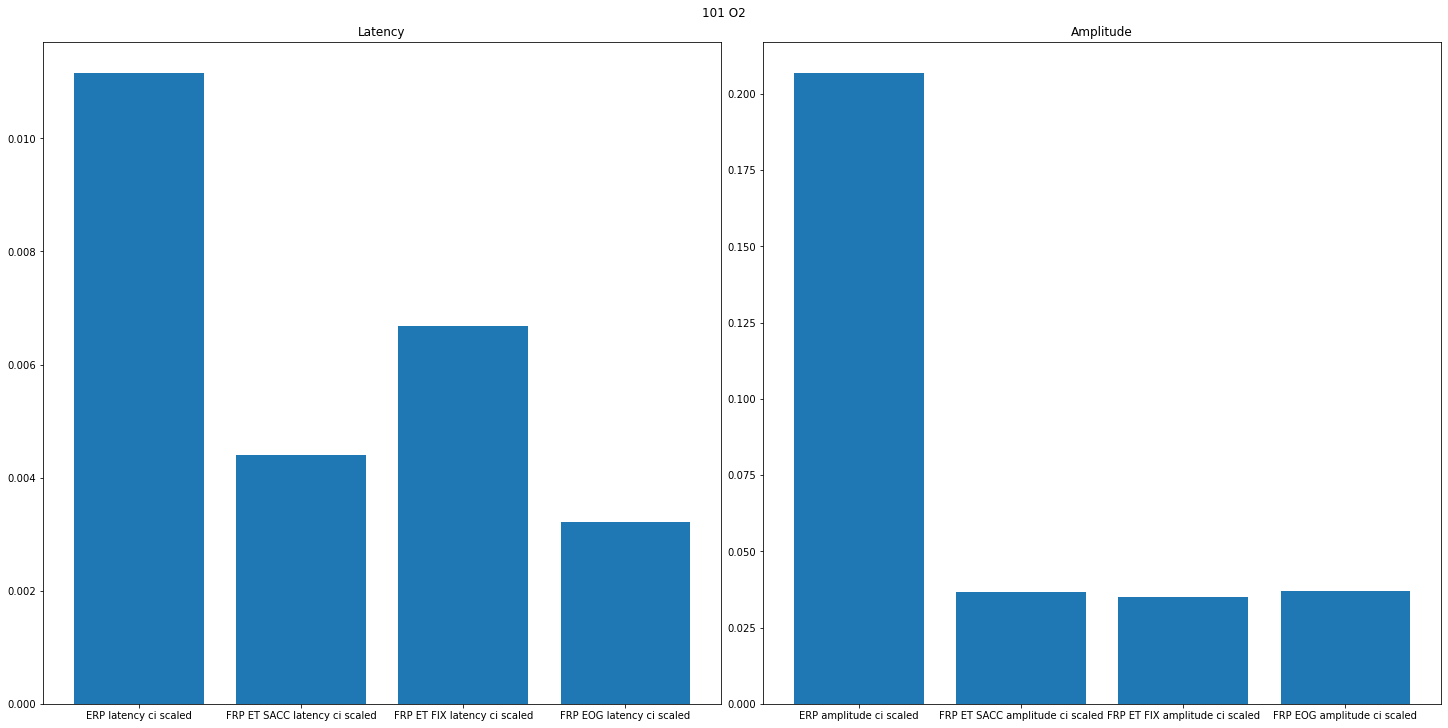

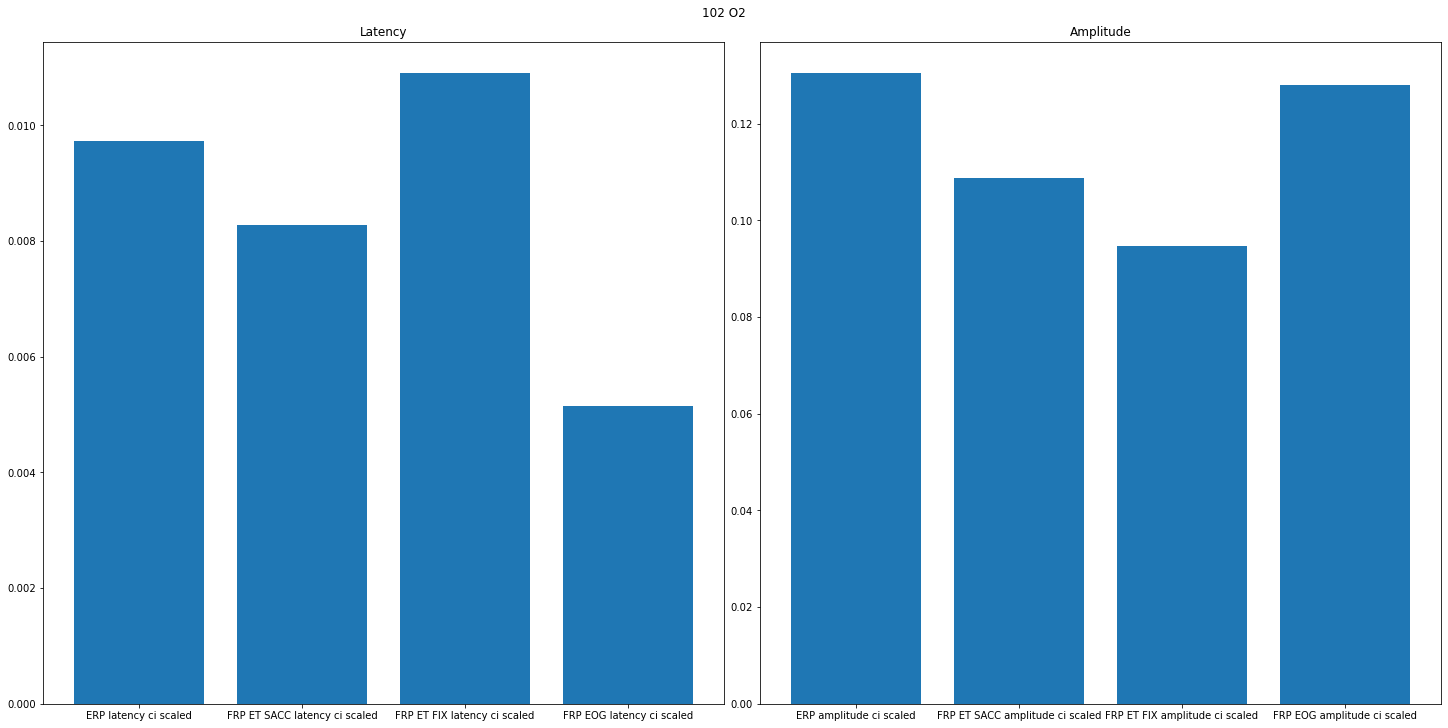

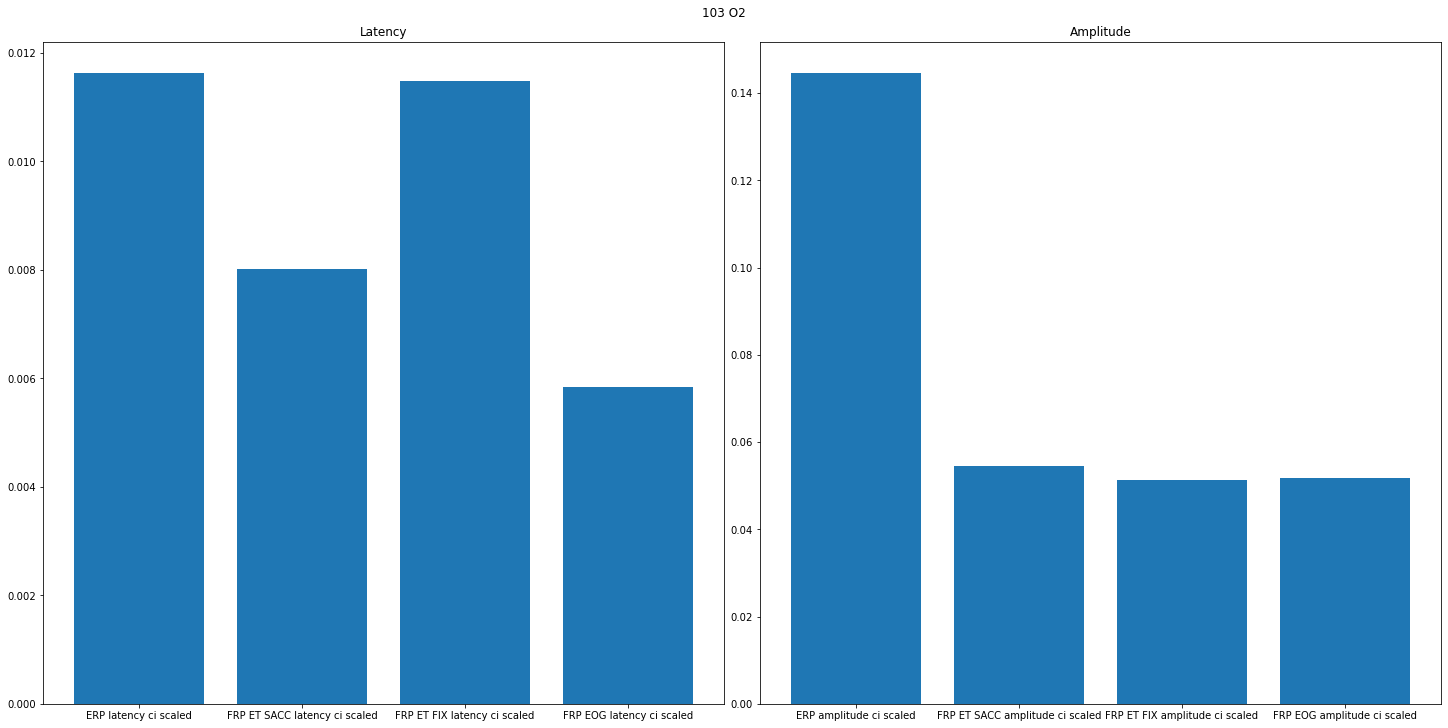

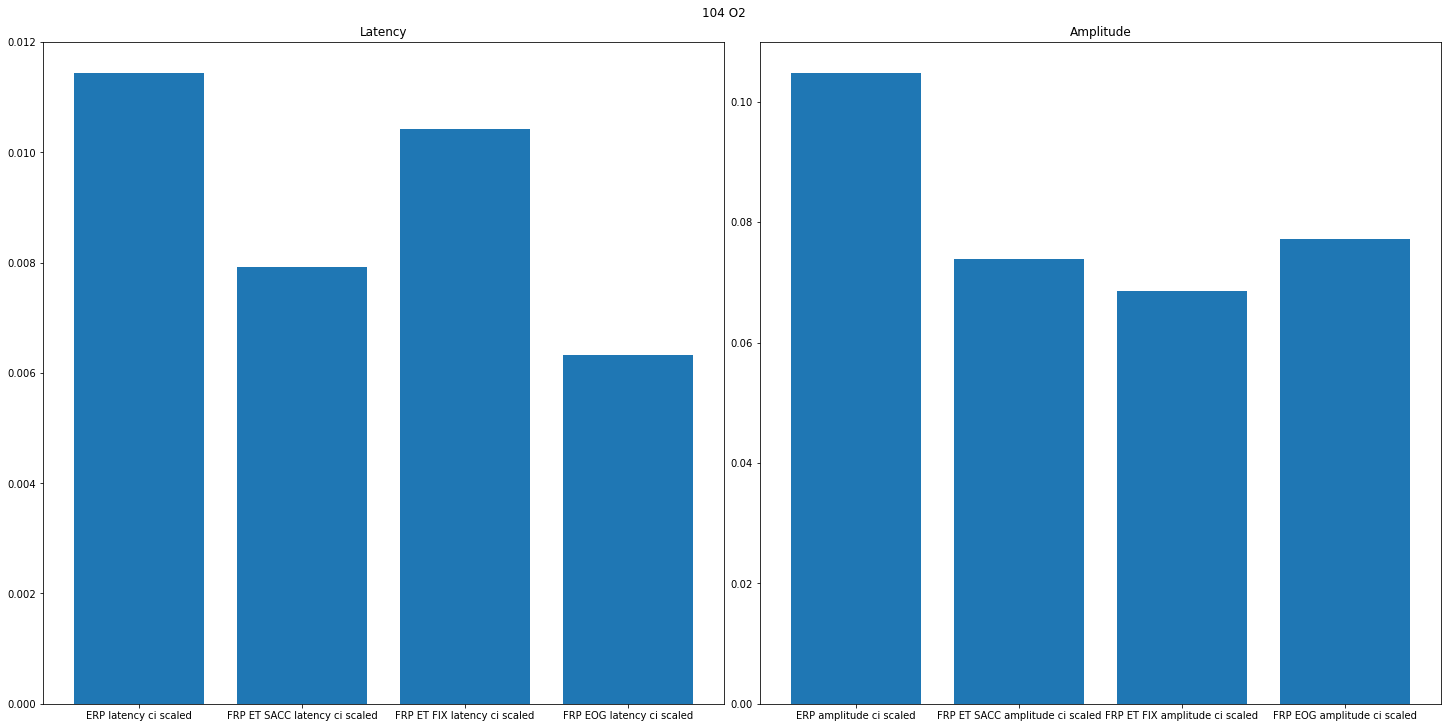

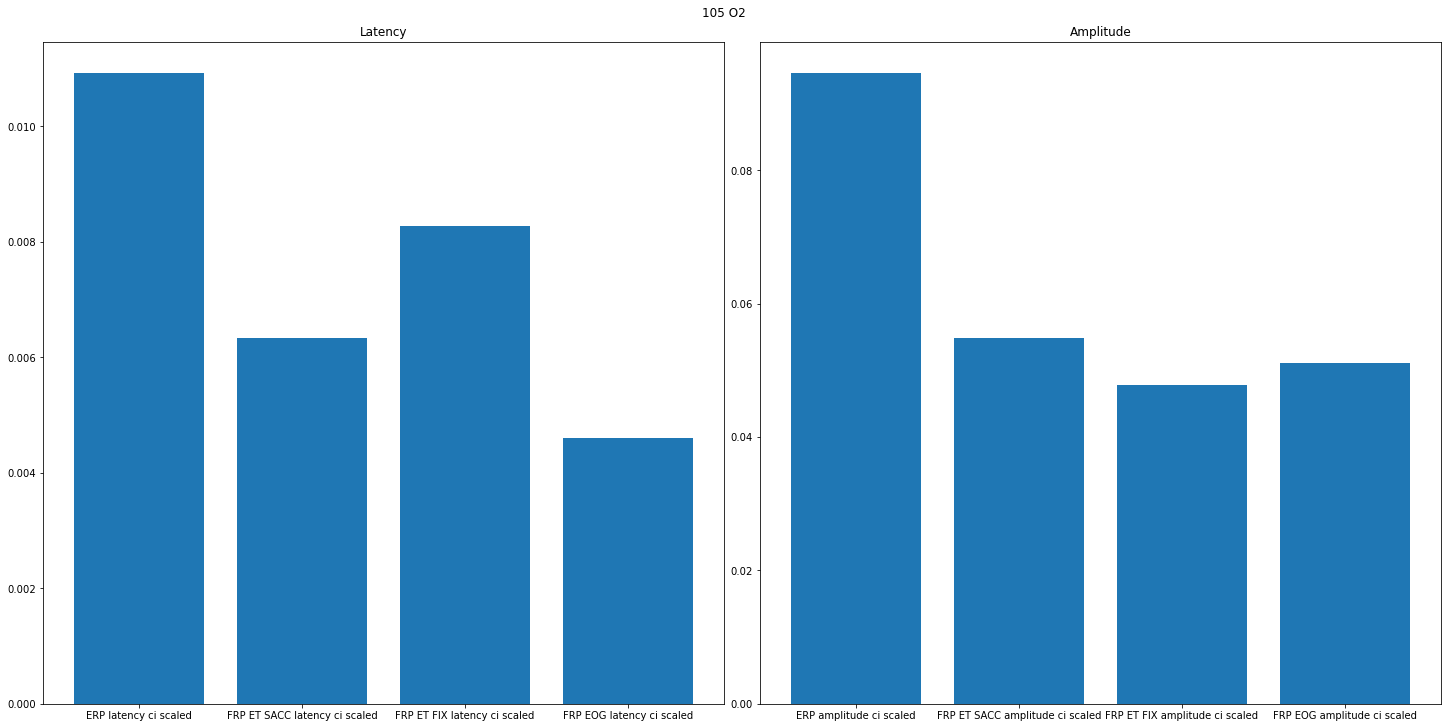

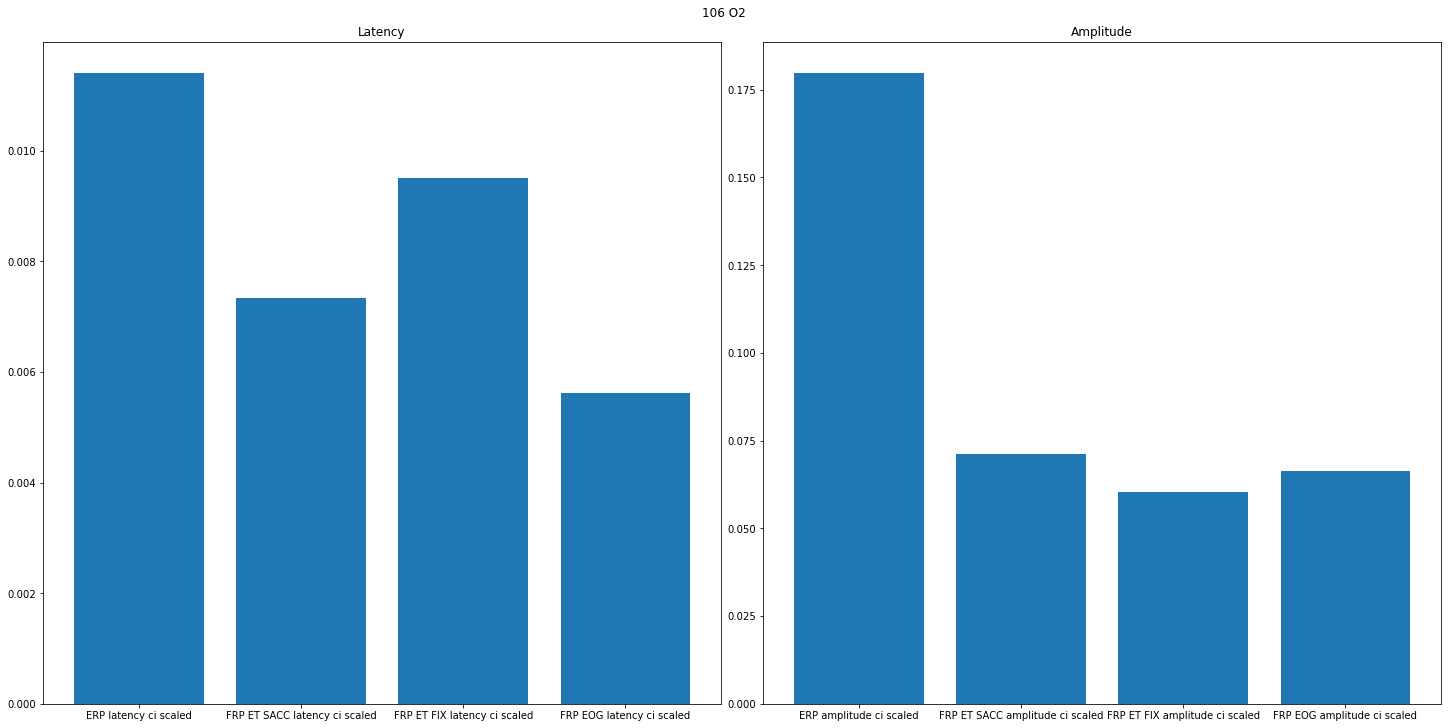

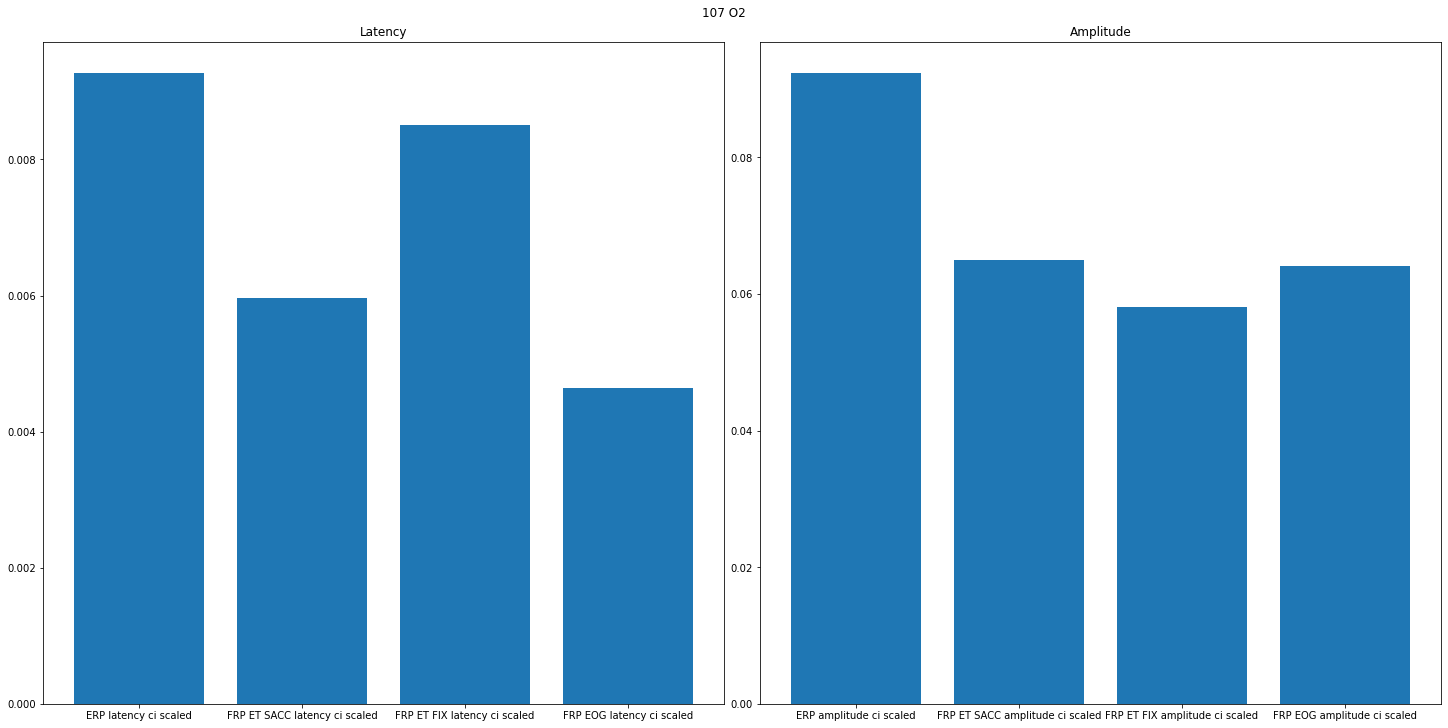

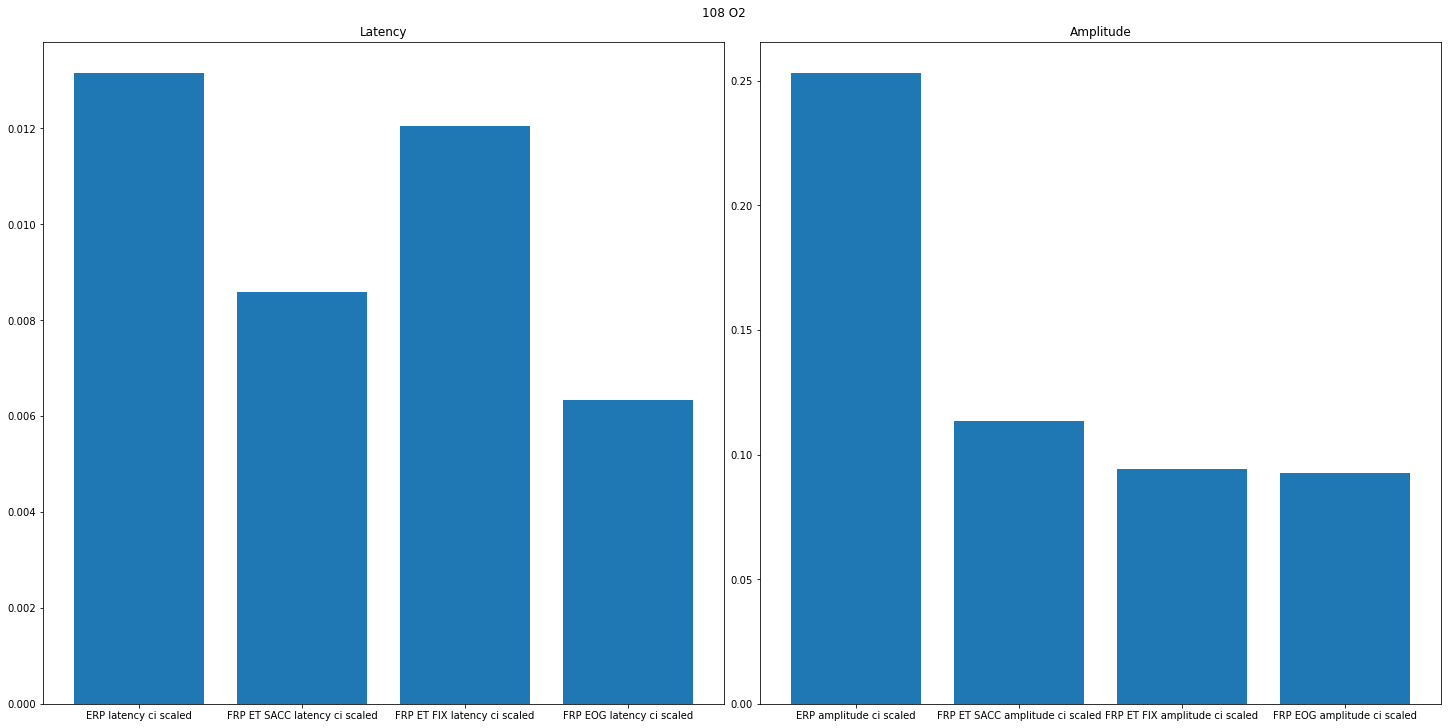

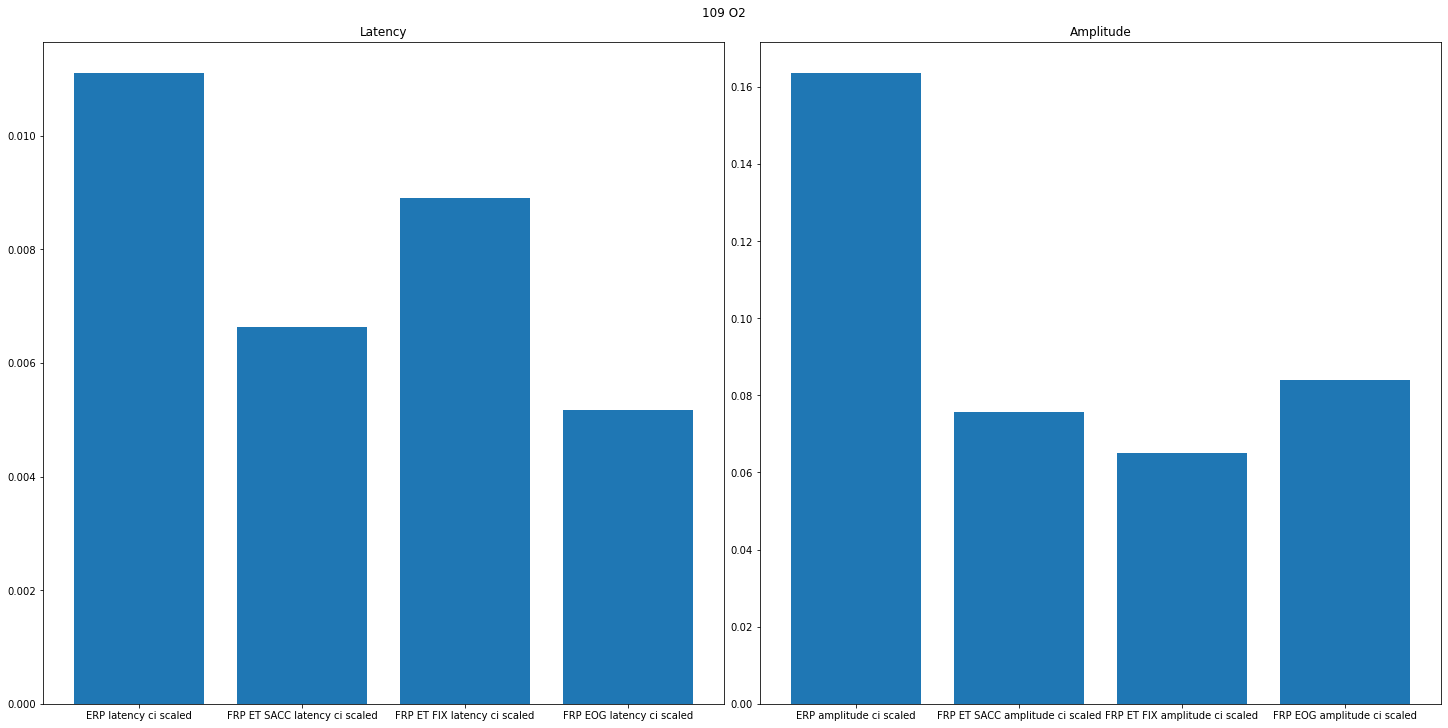

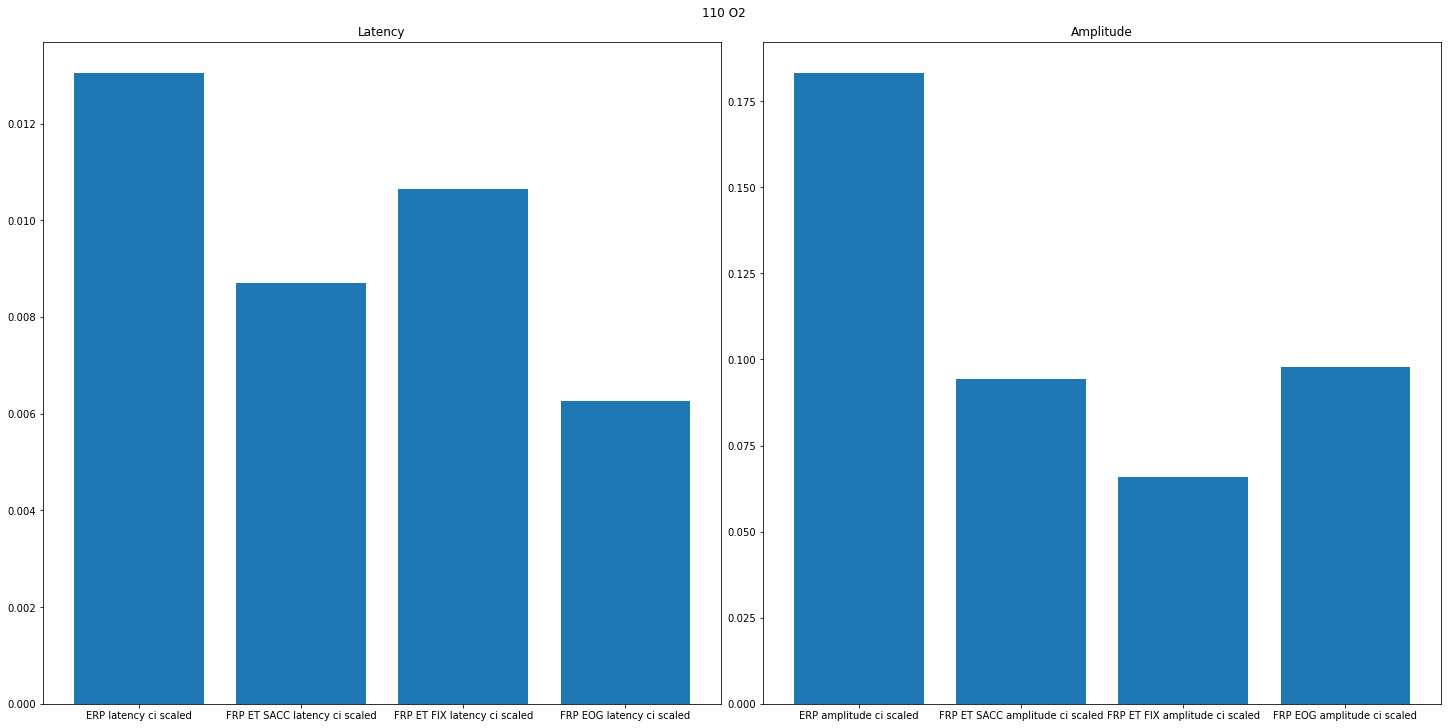

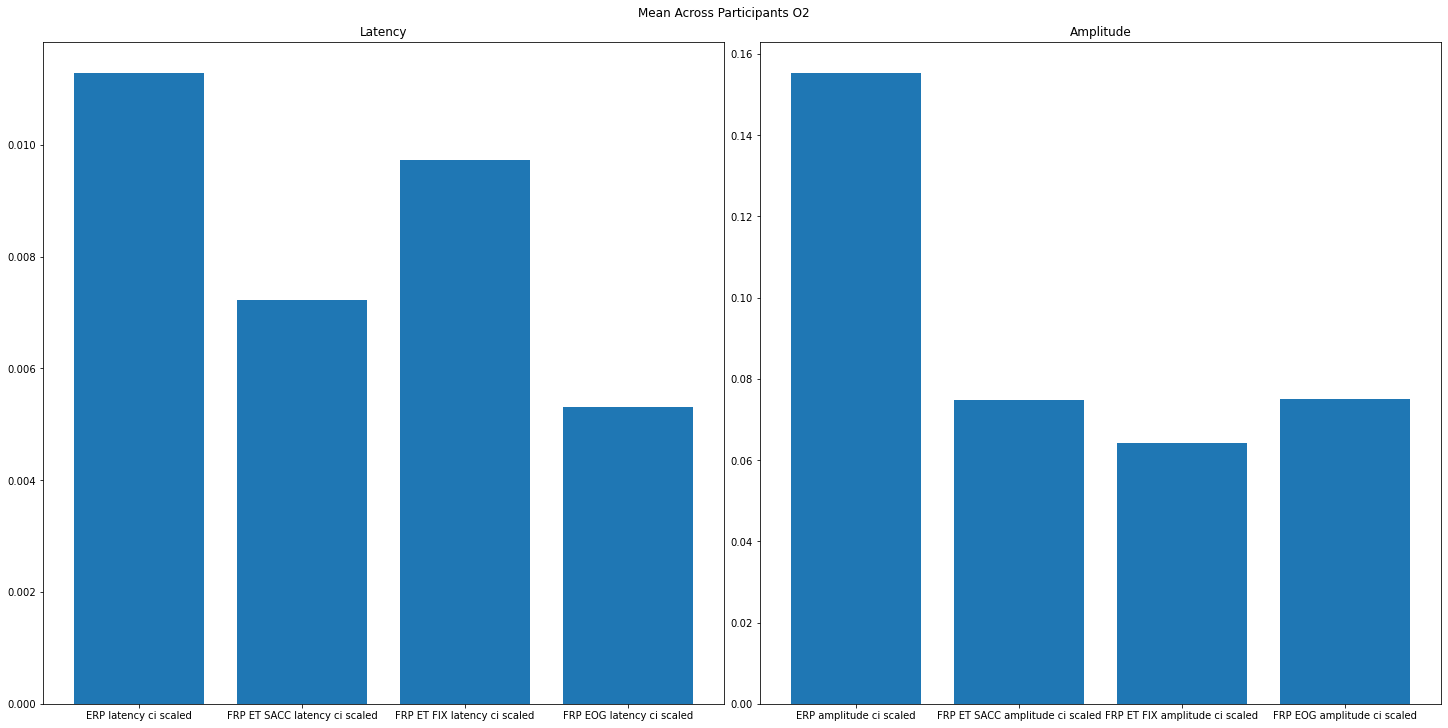

In [29]:
latency_amplitude_data_df = None 
for participant_num in range(101, 111):
    participant = participants[participant_num]
    participant.calc_peaks_amplitudes_latencies()
    if latency_amplitude_data_df is None:
        latency_amplitude_data_df = pd.DataFrame(columns=list(participant.latency_amplitude_data.keys()))
    
    latency_amplitude_data_df = latency_amplitude_data_df.append(participant.latency_amplitude_data, ignore_index=True)
    plot_participant_amplitudes_latencies_graph(participant.latency_amplitude_data)
    

cols = latency_amplitude_data_df.columns 
cols = [col for col in cols if " ci" in col]
mean_latency_amplitude_data = latency_amplitude_data_df.mean().to_dict()
mean_latency_amplitude_data['participant'] = 'Mean Across Participants'
mean_latency_amplitude_data['channel'] = 'O2'
plot_participant_amplitudes_latencies_graph(mean_latency_amplitude_data)


## Conclusion

This project includes two parts: deceting saccade onset if free viewing by EOG channels, and compare the within-subject single trial variability of four types of epochs: ERPs, FRPs detected by eye tracker locked to fixation onset, FRPs detected by eye tracker locked to saccade onset and FRPs detected by EOG channels locked to saccade onset.
The results for detecting saccade onset in free viewing, shows that the EOG channel detects most of the saccades onset detected by the eye tracker. Note that the false alarm ratio is very low, which indicates it is a reliable source for saccade detection.
The results for ERPs vs FRPs within-subject single trial variability indicates that the FRPs Lambda component is less variable than that of ERPs P1 component, and therfore may be a more reliable index as a measure of delay in conduction in MS patients. In addition, as the FRPs EOG provided similar results to that of FRP eye tracker, using FRPs instead of ERPs seems a vaiable option to be used clinically.  

## Ideas for Future Work

In this project, data evoked by categorical stimuli (faces and eggs\watches) was used. ...


## Bibliography 
1. Compston A, Coles A. Multiple sclerosis. Lancet. 2008 Oct 25;372(9648):1502-17. doi: 10.1016/S0140-6736(08)61620-7. PMID: 18970977.
2. D.F Scott, Adrienne Moffett, R.G Bickford. Comparison of two types of visual evoked potentials: Pattern reversal and eye movement (lambda). Electroencephalography and Clinical Neurophysiology, Volume 52, Issue 1. 1981. Pages 102-104. ISSN 0013-4694. https://doi.org/10.1016/0013-4694(81)90195-4.
3. Keren AS, Yuval-Greenberg S, Deouell LY. Saccadic spike potentials in gamma-band EEG: characterization, detection and suppression. Neuroimage. 2010 Feb 1;49(3):2248-63. doi: 10.1016/j.neuroimage.2009.10.057. Epub 2009 Oct 27. PMID: 19874901.
4. R.J. Billings. The origin of the occipital lambda wave in man. Electroencephalography and Clinical Neurophysiology, Volume 72, Issue 2. 1989. Pages 95-11. ISSN 0013-4694. https://doi.org/10.1016/0013-4694(89)90170-3.
